In [539]:
%matplotlib inline 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import sklearn
import datetime
import array 
import math

import shapefile as sf
from matplotlib.patches import Polygon
import mpld3

from censusgeocode import CensusGeocode
from matplotlib.collections import PatchCollection

In [5]:
def whichshape(lat,lon,path):
    sr = sf.Reader(path)
    shapes = sr.shapes()
    for i in range(len(shapes)):
        if inshape(lat,lon,shapes[i]):
            return i

In [6]:
def inshape(ptlat,ptlon,shape):
    # does not behave well near poles!!!
    pts = shape.points
    lat=[]
    lon=[]
    for pt in pts:
        lat.append(pt[1])
        lon.append(pt[0])
    lon_max=max(lon)
    lon_min=min(lon)
    lat_max=max(lat)
    lat_min=min(lat)
    
    if lon_min < -170 and lon_max > 170:
        for i in range(len(pts)):
            if pts[i][0]<0:
                pts[i][0] = 360+pts[i]
    
    if (ptlat > lat_max or ptlat < lat_min or
        ptlon > lon_max or ptlon < lon_min):
        return 0
    else:
        count = 0
        for i in range(len(pts)-1):
            line=[pts[i][0],pts[i][1],
                  pts[i+1][0],pts[i+1][1]]
                  
            if ((line[1] < ptlat and line[3] > ptlat) or 
                (line[1] > ptlat and line[3] < ptlat)):
               frac = (line[1]-ptlat)/(line[1]-line[3])
               if line[0]+frac*(line[2]-line[0]) > ptlon:
                    count+=1
        
        line=[pts[-1][0],pts[0][1],
              pts[-1][0],pts[0][1]]                  
        if line[1] < ptlat and line[3] > ptlat:
           frac = (line[1]-ptlat)/(line[1]-line[3])
           if line[0]+frac*(line[2]-line[0]) > ptlon:
                count+=1

    return count%2         

### 311 Request files

In [365]:
requests = pd.read_csv('DataforInsight.csv')

In [366]:
requests[['Problem Category', 'Case Number']].groupby('Problem Category').count().sort_values(by='Case Number')

,Case Number
Problem Category,
Over Irrigation,1
Parking Meter,34
Damaged Guardrail,61
Street Flooded,100
Dead Animal,122
Faded striping,193
Street Sweeping,258
Storm Drain,274
Tree Hazard,752


Isolate requests of interest

In [367]:
graffiti = requests.loc[np.where(requests['Problem Category']=='Graffiti')[0]]
graffiti.reset_index(drop=True, inplace=True)

dump = requests.loc[np.where(requests['Problem Category']=='Litter/Dumping')[0]]
dump.reset_index(drop=True, inplace=True)

lighting = requests.loc[np.where(requests['Problem Category']=='Street Light')[0]]
lighting.reset_index(drop=True, inplace=True)

In [368]:
len(graffiti), len(dump), len(lighting)

(3600, 1665, 1515)

### Extract Census linking information for request locations 

In [540]:
cg = CensusGeocode()

In [542]:
requests['block']=None
requests['tract']=None
requests['geoid']=None
requests['blockgroup']=None

In [605]:
start = datetime.datetime.now()

for i in range(8632,len(requests)): 
    if ((requests.loc[i,'Geolocation (Longitude)']!=0.0) 
        & (np.isnan(requests.loc[i,'Geolocation (Longitude)'])==False)) :
        temp1 = cg.coordinates(x=requests.loc[i,'Geolocation (Longitude)'], 
                              y=requests.loc[i, 'Geolocation (Latitude)'])
        if (len(temp1[0]['2010 Census Blocks'])>0):
            if ('status' not in temp1[0]['2010 Census Blocks'][0].keys()[0]): 
                temp = temp1[0]['2010 Census Blocks'][0]
                if (temp is not None):
                    requests.loc[i, 'block'] = temp['BLOCK']
                    requests.loc[i, 'tract'] = temp['TRACT']
                    requests.loc[i, 'geoid'] = temp['GEOID']
                    requests.loc[i, 'blockgroup'] = temp['BLKGRP']

                if (i % 100 == 0): 
                    finish = datetime.datetime.now()
                    print i, finish-start
                    start = datetime.datetime.now()



2300 0:00:18.802752
2400 0:01:27.859077
2500 0:01:23.968834
2600 0:01:07.529968
2700 0:01:08.568634
2800 0:01:04.707289
2900 0:01:12.845838
3000 0:01:36.935633
3100 0:01:09.018208
3200 0:01:03.590652
3300 0:01:16.185814
3400 0:01:14.240512
3500 0:01:08.327857
3600 0:01:10.015500
3700 0:01:23.660773
3800 0:01:05.843988
3900 0:01:08.506000
4000 0:01:09.939548
4100 0:01:17.414963
4200 0:01:06.866518
4300 0:01:04.000021
4400 0:00:58.447134
4500 0:01:13.075431
4600 0:01:07.088593
4700 0:00:58.415733
4800 0:01:09.057999
4900 0:01:10.409473
5000 0:00:58.766374
5100 0:01:02.682910
5200 0:01:13.420996
5300 0:01:21.013541
5400 0:01:19.139378
5500 0:01:00.136981
5600 0:01:05.408095
5700 0:01:14.126597
5800 0:01:08.617067
5900 0:01:05.948190
6000 0:00:57.445686
6100 0:01:08.814470
6200 0:01:07.008088
6300 0:01:03.550922
6400 0:01:09.873467
6500 0:01:07.752194
6600 0:01:12.092456
6700 0:01:09.189175
6800 0:01:17.205062
6900 0:01:01.086159
7000 0:01:24.081460
7100 0:01:28.649720
7200 0:01:31.240742


ConnectionError: ('Connection aborted.', error(32, 'Broken pipe'))

In [607]:
requests.to_csv('output_files/requests_processed_start.csv', index=False)

In [608]:
barf = pd.read_csv('output_files/requests_processed_start.csv')

In [609]:
barf.head()

,Case Number,Parent Case Number,Status,Mobile/Web Status,Duplicate Verified,Override Duplicate,Functional Location,Question #1,Answer #1,Answer #1 Options,...,SAP System Status,SAP User Status,Short Description,SLA,SAP URL,Case Record Type,block,tract,geoid,blockgroup
0,91250,0.0,Closed - Referred,Referred,0.0,0.0,SS-018797,NaN,NaN,NaN,...,NaN,NaN,Curb Maintenance,NaN,https://getitdone.force.com//TSWViewReportDeta...,Street Division Closed Case,3002.0,1200.0,6.073001e+13,3.0
1,102901,0.0,Closed,Closed,0.0,0.0,SS-014392,Stop sign?,No,NaN,...,NOCO,CMPL,4251 J StTraffic...,NaN,https://getitdone.force.com//TSWViewReportDeta...,Street Division Closed Case,3009.0,3403.0,6.073003e+13,3.0
2,100070,0.0,Closed,Closed,0.0,0.0,SS-016716,NaN,NaN,NaN,...,NOCO,CMPL,1712#1798 Logan AvePothole,NaN,https://getitdone.force.com//TSWViewReportDeta...,Street Division Closed Case,2035.0,5100.0,6.073005e+13,2.0
3,97244,0.0,Closed - Referred,Referred,0.0,0.0,SS-000921,Identify the vehicle type?,Other,NaN,...,NaN,NaN,NaN,NaN,https://getitdone.force.com//TSWViewReportDeta...,Street Division,4011.0,2100.0,6.073002e+13,4.0
4,86783,0.0,Closed - Referred,Referred,1.0,0.0,SS-019478,Identify the problem,Other,NaN,...,NaN,NaN,Sidewalk Deficiency,NaN,https://getitdone.force.com//TSWViewReportDeta...,Street Division Closed Case,1006.0,8311.0,6.073008e+13,1.0


In [597]:
if ('Layer query' in temp1[0]['2010 Census Blocks'][0]['status']): 
    print 'hello'

hello


In [600]:
temp1[0]['2010 Census Blocks'][0].keys()[0]

u'status'

In [602]:
if ('status' in temp1[0]['2010 Census Blocks'][0].keys()[0]): 
    print 'hello'

hello


In [584]:
temp2 = cg.coordinates(x=requests.loc[i,'Geolocation (Longitude)'], 
                              y=requests.loc[i, 'Geolocation (Latitude)'])

In [606]:
print i 
temp1

8632


[{u'2010 Census Blocks': [{u'AREALAND': 10246,
    u'AREAWATER': 0,
    u'BASENAME': u'5000',
    u'BLKGRP': u'5',
    u'BLOCK': u'5000',
    u'CENTLAT': u'+32.7460178',
    u'CENTLON': u'-117.1641491',
    u'COUNTY': u'073',
    u'FUNCSTAT': u'S',
    u'GEOID': u'060730003005000',
    u'INTPTLAT': u'+32.7460178',
    u'INTPTLON': u'-117.1641491',
    u'LSADC': u'BK',
    u'LWBLKTYP': u'L',
    u'MTFCC': u'G5040',
    u'NAME': u'Block 5000',
    u'OBJECTID': 10084124,
    u'OID': 210404038353862,
    u'STATE': u'06',
    u'SUFFIX': u'',
    u'TRACT': u'000300'}],
  u'Census Tracts': [{u'AREALAND': 898761,
    u'AREAWATER': 0,
    u'BASENAME': u'3',
    u'CENTLAT': u'+32.7447827',
    u'CENTLON': u'-117.1623035',
    u'COUNTY': u'073',
    u'FUNCSTAT': u'S',
    u'GEOID': u'06073000300',
    u'INTPTLAT': u'+32.7447827',
    u'INTPTLON': u'-117.1623035',
    u'LSADC': u'CT',
    u'MTFCC': u'G5020',
    u'NAME': u'Census Tract 3',
    u'OBJECTID': 37366,
    u'OID': 20790676338501,
    u'

In [363]:
#graffiti.to_csv('output_files/graffiti_geocoder.csv', index=False)

In [371]:
graffiti = pd.read_csv('output_files/graffiti_geocoder.csv')

#### Using Tim's code instead of geocoder:

Trim shapefile down to San Diego County

In [10]:
r = sf.Reader('shapefiles/tl_2016_06_bg/tl_2016_06_bg.shp')
w = sf.Writer(shapeType=sf.POLYGON)

In [11]:
# Copy the fields to the writer
w.fields = list(r.fields)

In [12]:
# Grab the geometry and records from all features 
# with the correct county name 
selection = [] 
for rec in enumerate(r.records()):
    if ((rec[1][1]=='073') & (rec[1][3]!='0')):
          selection.append(rec) 
# Add the geometry and records to the writer

for rec in selection:
    w._shapes.append(r.shape(rec[0]))
    w.records.append(rec[1])
# Save the new shapefile
w.save("shapefiles/sandiego_county_blockgroups") 

Match each 311 report with it's associated block group

In [62]:
temporary = lighting 

temporary['block_group']=None
temporary['tract']=None
temporary['geoid']=None

reading = sf.Reader('shapefiles/sandiego_county_blockgroups.shp')

start = datetime.datetime.now()

for i in range(0,len(lighting)): 
    if (temporary.loc[i,'Geolocation (Longitude)']!=0.0) :
        temp = whichshape(temporary.loc[i,'Geolocation (Latitude)'], 
                          temporary.loc[i, 'Geolocation (Longitude)'], 
                          'shapefiles/sandiego_county_blockgroups.shp')
        if (temp is not None):
            temporary.loc[i, 'block_group'] = reading.records()[temp][3]
            temporary.loc[i, 'tract'] = reading.records()[temp][2]
            temporary.loc[i, 'geoid'] = reading.records()[temp][4]
        
    if (i % 100 == 0): 
        finish = datetime.datetime.now()
        print i, finish-start
        start = datetime.datetime.now()



0 0:00:00.920797
100 0:01:41.484810
200 0:01:38.798607
300 0:01:41.140341
400 0:01:44.568110
500 0:01:42.041521
600 0:01:42.453154
700 0:01:42.134142
800 0:01:43.106106
900 0:01:42.113004
1000 0:01:41.735002
1100 0:01:41.449113
1200 0:01:40.819706
1300 0:01:43.134757


In [63]:
## Reset the data frame to updated version
lighting = temporary

#temporary.to_csv('output_files/lighting_blockgroups.csv', index=False)

Read in the files that I've previously processed: 

In [373]:
#graffiti = pd.read_csv('output_files/graffiti_blockgroups.csv')
#dump = pd.read_csv('output_files/dump_blockgroups.csv')
#lighting = pd.read_json('output_files/lighting_blockgroups.json')

### Check for graffiti report duplicates

In [374]:
#graffiti.loc[np.where(graffiti['Public Description'].str.contains('multiple')==True)[0], 'Public Description']

Determine the frequency of problems in each block group

In [375]:
graffiti['count'] = 1

In [376]:
graffiti_freq = graffiti[['tract', 'block_group', 'count']].groupby(['tract', 'block_group'], as_index=False).agg('count')

In [377]:
graffiti_freq['tract'] = graffiti_freq['tract'].astype(int)
graffiti_freq['block_group'] = graffiti_freq['block_group'].astype(int)

In [378]:
dump['dump_count'] = 1
dump_freq = dump[['tract', 'block_group', 'dump_count']].groupby(['tract', 
                                                                  'block_group'], 
                                                                 as_index=False).agg('count')

In [379]:
dump_freq['tract'] = dump_freq['tract'].astype(int)
dump_freq['block_group'] = dump_freq['block_group'].astype(int)

In [380]:
lighting['lighting_count'] = 1

In [381]:
lighting_freq = lighting[['tract', 'block_group', 'lighting_count']].groupby(['tract', 
                                                                              'block_group'], 
                                                                             as_index=False).agg('count')

In [382]:
lighting_freq.rename(columns={'count' : 'lighting_count'}, inplace=True)
lighting_freq['tract'] = lighting_freq['tract'].astype(int)
lighting_freq['block_group'] = lighting_freq['block_group'].astype(int)

Combine information on graffiti, lighting, and dumping. 

In [383]:
graffiti_freq2 = pd.merge(graffiti_freq, dump_freq, on=['tract', 'block_group'], how='left')

In [384]:
graffiti_freq3 = pd.merge(graffiti_freq2, lighting_freq, on=['tract', 'block_group'], how='left')

In [385]:
graffiti_freq = graffiti_freq3.copy()

In [390]:
graffiti_freq.loc[np.where(np.isnan(graffiti_freq['lighting_count'])==True)[0], 'lighting_count'] = 0.0
graffiti_freq.loc[np.where(np.isnan(graffiti_freq['dump_count'])==True)[0], 'dump_count'] = 0.0

### Match with Census data, organised by Block Group

In [396]:
filenames='aff/block_groups/*with_ann.csv'
test=glob.glob(filenames)

In [404]:
#i=0
#temp = pd.read_csv(test[i], header=1, low_memory=False)
#print test[i]
#print temp.columns.values

In [405]:
age = [0, 1]
totals = [2]
race = [10]
income = [16, 17, 18, 19]
propvals = [20, 25, 28]
geography = [30]

all_of_interest = [30, 0, 1, 2, 10, 16, 17, 18, 19, 20, 25, 28]

In [406]:
for i in all_of_interest: 
    temp = pd.read_csv(test[i], header=1, low_memory=False)
    print i, i, i 
    if (i==30): 
        census = temp.copy()
    if (i!=30): 
        combo = pd.merge(census, temp, on='Id', how='left', suffixes=('', '_' + str(i)))
        census = combo.copy()
        census.reset_index(drop=True)

30 30 30
0 0 0
1 1 1
2 2 2
10 10 10
16 16 16
17 17 17
18 18 18
19 19 19
20 20 20
25 25 25
28 28 28


In [418]:
temp = pd.Series(census.columns.values)[np.where((pd.Series(census.columns.values).str.contains('Margin of Error')==False) & 
                                         (pd.Series(census.columns.values).str.contains('Geography_')==False) & 
                                         (pd.Series(census.columns.values).str.contains('Id2_')==False) & 
                                         (pd.Series(census.columns.values).str.contains('Estimate; Total:_')==False) & 
                                         (pd.Series(census.columns.values).str.contains('RECORD CODES')==False))[0]]

In [430]:
# Output temp to a csv file and trim manually
census_trimmed = census[list(temp['Id'])]

In [144]:
"""
census_trimmed = census[[ 'Id', 'Id2', 'GEOGRAPHIC AREA CODES - Census Tract', 
                         'GEOGRAPHIC AREA CODES - Block Group', 
                         'Estimate; Median age -- - Total:', 
                         'Estimate; Median age -- - Male', 
                         'Estimate; Median age -- - Female', 
                         'Estimate; Total', 'Estimate; Not Hispanic or Latino:', 
                         'Estimate; Not Hispanic or Latino: - White alone', 
                         'Estimate; Not Hispanic or Latino: - Black or African American alone', 
                         'Estimate; Not Hispanic or Latino: - American Indian and Alaska Native alone', 
                         'Estimate; Not Hispanic or Latino: - Asian alone', 
                         'Estimate; Not Hispanic or Latino: - Native Hawaiian and Other Pacific Islander alone', 
                         'Estimate; Not Hispanic or Latino: - Some other race alone', 
                         'Estimate; Not Hispanic or Latino: - Two or more races:', 
                         'Estimate; Not Hispanic or Latino: - Two or more races: - Two races including Some other race', 
                         'Estimate; Not Hispanic or Latino: - Two or more races: - Two races excluding Some other race, and three or more races', 
                         'Estimate; Hispanic or Latino:', 'Estimate; Total: - Less than $10,000', 
                         'Estimate; Total: - $10,000 to $14,999', 'Estimate; Total: - $15,000 to $19,999', 
                         'Estimate; Total: - $20,000 to $24,999', 'Estimate; Total: - $25,000 to $29,999', 
                         'Estimate; Total: - $30,000 to $34,999', 'Estimate; Total: - $35,000 to $39,999', 
                         'Estimate; Total: - $40,000 to $44,999', 'Estimate; Total: - $45,000 to $49,999', 
                         'Estimate; Total: - $50,000 to $59,999', 'Estimate; Total: - $60,000 to $74,999', 
                         'Estimate; Total: - $75,000 to $99,999', 'Estimate; Total: - $100,000 to $124,999', 
                         'Estimate; Total: - $125,000 to $149,999', 'Estimate; Total: - $150,000 to $199,999', 
                         'Estimate; Total: - $200,000 or more', 
                         'Estimate; Median household income in the past 12 months (in 2014 Inflation-adjusted dollars)', 
                         'Estimate; Total: - With public assistance income', 
                         'Estimate; Total: - No public assistance income', 
                         'Estimate; Per capita income in the past 12 months (in 2014 Inflation-adjusted dollars)', 
                         'Estimate; Total: - Owner occupied', 'Estimate; Total: - Renter occupied', 
                         'Estimate; With cash rent: - Less than $100', 'Estimate; With cash rent: - $100 to $149', 
                         'Estimate; With cash rent: - $150 to $199', 'Estimate; With cash rent: - $200 to $249', 
                         'Estimate; With cash rent: - $250 to $299', 'Estimate; With cash rent: - $300 to $349', 
                         'Estimate; With cash rent: - $350 to $399', 'Estimate; With cash rent: - $400 to $449', 
                         'Estimate; With cash rent: - $450 to $499', 'Estimate; With cash rent: - $500 to $549', 
                         'Estimate; With cash rent: - $550 to $599', 'Estimate; With cash rent: - $600 to $649', 
                         'Estimate; With cash rent: - $650 to $699', 'Estimate; With cash rent: - $700 to $749', 
                         'Estimate; With cash rent: - $750 to $799', 'Estimate; With cash rent: - $800 to $899', 
                         'Estimate; With cash rent: - $900 to $999', 'Estimate; With cash rent: - $1,000 to $1,249', 
                         'Estimate; With cash rent: - $1,250 to $1,499', 
                         'Estimate; With cash rent: - $1,500 to $1,999', 
                         'Estimate; With cash rent: - $2,000 or more', 'Estimate; No cash rent', 
                         'Estimate; Median value (dollars)']]
"""

In [431]:
census_trimmed.reset_index(drop=True, inplace=True)

In [432]:
census_trimmed.rename(columns={'GEOGRAPHIC AREA CODES - Census Tract': 'tract', 
                               'GEOGRAPHIC AREA CODES - Block Group': 'block_group'}, inplace=True)

Merge census data with graffiti/lighting/dumping frequency data

In [435]:
census_trimmed.replace({'-': None}, regex=True, inplace=True)
census_trimmed.replace({'**': None}, inplace=True)
census_trimmed.replace({'1,000,000+': '1000000'}, inplace=True)
census_trimmed.replace({'***': None}, inplace=True)

/Users/kschles/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:3362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  limit=limit, regex=regex)


In [436]:
census_gfreq = pd.merge(graffiti_freq, census_trimmed, on=['tract', 'block_group'], how='left')

In [502]:
census_numeric = census_gfreq.select_dtypes(exclude=['object'])

In [148]:
#census_gfreq.to_csv('output_files/census_gfreq.csv', index=False)

In [149]:
#census_gfreq = pd.read_csv('output_files/census_gfreq.csv')

In [503]:
# Doesn't currently work for all columns
for i in census_numeric.columns.values: 
    census_numeric.loc[np.where(np.isnan(census_numeric[i])==True)[0], i] = 0.0

In [449]:
census_numeric.columns.values

array(['tract', 'block_group', 'count', 'dump_count', 'lighting_count',
       'Id2', 'Estimate; Total:', 'Estimate; Male:',
       'Estimate; Male: - Under 5 years', 'Estimate; Male: - 5 to 9 years',
       'Estimate; Male: - 10 to 14 years',
       'Estimate; Male: - 15 to 17 years',
       'Estimate; Male: - 18 and 19 years', 'Estimate; Male: - 20 years',
       'Estimate; Male: - 21 years', 'Estimate; Male: - 22 to 24 years',
       'Estimate; Male: - 25 to 29 years',
       'Estimate; Male: - 30 to 34 years',
       'Estimate; Male: - 35 to 39 years',
       'Estimate; Male: - 40 to 44 years',
       'Estimate; Male: - 45 to 49 years',
       'Estimate; Male: - 50 to 54 years',
       'Estimate; Male: - 55 to 59 years',
       'Estimate; Male: - 60 and 61 years',
       'Estimate; Male: - 62 to 64 years',
       'Estimate; Male: - 65 and 66 years',
       'Estimate; Male: - 67 to 69 years',
       'Estimate; Male: - 70 to 74 years',
       'Estimate; Male: - 75 to 79 years',
     

Calculate percentages by population rather than number of people. Note that the Estimate total does not always correspond with a category break down, so better off calculating sums and then using these for division. 

In [504]:
# Racial Breakdown: 
race_bkdwn = census_numeric[['Estimate; Not Hispanic or Latino: - White alone',
                             'Estimate; Not Hispanic or Latino: - Black or African American alone',
                             'Estimate; Not Hispanic or Latino: - American Indian and Alaska Native alone',
                             'Estimate; Not Hispanic or Latino: - Asian alone',
                             'Estimate; Not Hispanic or Latino: - Native Hawaiian and Other Pacific Islander alone',
                             'Estimate; Not Hispanic or Latino: - Some other race alone',
                             'Estimate; Not Hispanic or Latino: - Two or more races:',
                             'Estimate; Hispanic or Latino:']].copy()

race_sum = race_bkdwn.sum(axis=1)

census_numeric[['Estimate; Not Hispanic or Latino: - White alone',
                             'Estimate; Not Hispanic or Latino: - Black or African American alone',
                             'Estimate; Not Hispanic or Latino: - American Indian and Alaska Native alone',
                             'Estimate; Not Hispanic or Latino: - Asian alone',
                             'Estimate; Not Hispanic or Latino: - Native Hawaiian and Other Pacific Islander alone',
                             'Estimate; Not Hispanic or Latino: - Some other race alone',
                             'Estimate; Not Hispanic or Latino: - Two or more races:',
                             'Estimate; Hispanic or Latino:']] = race_bkdwn.div(race_sum, axis=0)

In [506]:
# Age Breakdown (Male): 
age_bkdwn = census_numeric[[
       'Estimate; Male: - Under 5 years', 'Estimate; Male: - 5 to 9 years',
       'Estimate; Male: - 10 to 14 years',
       'Estimate; Male: - 15 to 17 years',
       'Estimate; Male: - 18 and 19 years', 'Estimate; Male: - 20 years',
       'Estimate; Male: - 21 years', 'Estimate; Male: - 22 to 24 years',
       'Estimate; Male: - 25 to 29 years',
       'Estimate; Male: - 30 to 34 years',
       'Estimate; Male: - 35 to 39 years',
       'Estimate; Male: - 40 to 44 years',
       'Estimate; Male: - 45 to 49 years',
       'Estimate; Male: - 50 to 54 years',
       'Estimate; Male: - 55 to 59 years',
       'Estimate; Male: - 60 and 61 years',
       'Estimate; Male: - 62 to 64 years',
       'Estimate; Male: - 65 and 66 years',
       'Estimate; Male: - 67 to 69 years',
       'Estimate; Male: - 70 to 74 years',
       'Estimate; Male: - 75 to 79 years',
       'Estimate; Male: - 80 to 84 years',
       'Estimate; Male: - 85 years and over']].copy()

age_sum = age_bkdwn.sum(axis=1)

census_numeric[[
       'Estimate; Male: - Under 5 years', 'Estimate; Male: - 5 to 9 years',
       'Estimate; Male: - 10 to 14 years',
       'Estimate; Male: - 15 to 17 years',
       'Estimate; Male: - 18 and 19 years', 'Estimate; Male: - 20 years',
       'Estimate; Male: - 21 years', 'Estimate; Male: - 22 to 24 years',
       'Estimate; Male: - 25 to 29 years',
       'Estimate; Male: - 30 to 34 years',
       'Estimate; Male: - 35 to 39 years',
       'Estimate; Male: - 40 to 44 years',
       'Estimate; Male: - 45 to 49 years',
       'Estimate; Male: - 50 to 54 years',
       'Estimate; Male: - 55 to 59 years',
       'Estimate; Male: - 60 and 61 years',
       'Estimate; Male: - 62 to 64 years',
       'Estimate; Male: - 65 and 66 years',
       'Estimate; Male: - 67 to 69 years',
       'Estimate; Male: - 70 to 74 years',
       'Estimate; Male: - 75 to 79 years',
       'Estimate; Male: - 80 to 84 years',
       'Estimate; Male: - 85 years and over']] = age_bkdwn.div(age_sum, axis=0)

In [507]:
income_bkdwn=census_numeric[['Estimate; Total: - Less than $10,000',
       'Estimate; Total: - $10,000 to $14,999',
       'Estimate; Total: - $15,000 to $19,999',
       'Estimate; Total: - $20,000 to $24,999',
       'Estimate; Total: - $25,000 to $29,999',
       'Estimate; Total: - $30,000 to $34,999',
       'Estimate; Total: - $35,000 to $39,999',
       'Estimate; Total: - $40,000 to $44,999',
       'Estimate; Total: - $45,000 to $49,999',
       'Estimate; Total: - $50,000 to $59,999',
       'Estimate; Total: - $60,000 to $74,999',
       'Estimate; Total: - $75,000 to $99,999',
       'Estimate; Total: - $100,000 to $124,999',
       'Estimate; Total: - $125,000 to $149,999',
       'Estimate; Total: - $150,000 to $199,999',
       'Estimate; Total: - $200,000 or more']].copy()

income_sum = income_bkdwn.sum(axis=1)

census_numeric[['Estimate; Total: - Less than $10,000',
       'Estimate; Total: - $10,000 to $14,999',
       'Estimate; Total: - $15,000 to $19,999',
       'Estimate; Total: - $20,000 to $24,999',
       'Estimate; Total: - $25,000 to $29,999',
       'Estimate; Total: - $30,000 to $34,999',
       'Estimate; Total: - $35,000 to $39,999',
       'Estimate; Total: - $40,000 to $44,999',
       'Estimate; Total: - $45,000 to $49,999',
       'Estimate; Total: - $50,000 to $59,999',
       'Estimate; Total: - $60,000 to $74,999',
       'Estimate; Total: - $75,000 to $99,999',
       'Estimate; Total: - $100,000 to $124,999',
       'Estimate; Total: - $125,000 to $149,999',
       'Estimate; Total: - $150,000 to $199,999',
       'Estimate; Total: - $200,000 or more'
       ]] = income_bkdwn.div(income_sum, axis=0)

In [509]:
rent_bkdwn=census_numeric[['Estimate; With cash rent: - Less than $100',
       'Estimate; With cash rent: - $100 to $149',
       'Estimate; With cash rent: - $150 to $199',
       'Estimate; With cash rent: - $200 to $249',
       'Estimate; With cash rent: - $250 to $299',
       'Estimate; With cash rent: - $300 to $349',
       'Estimate; With cash rent: - $350 to $399',
       'Estimate; With cash rent: - $400 to $449',
       'Estimate; With cash rent: - $450 to $499',
       'Estimate; With cash rent: - $500 to $549',
       'Estimate; With cash rent: - $550 to $599',
       'Estimate; With cash rent: - $600 to $649',
       'Estimate; With cash rent: - $650 to $699',
       'Estimate; With cash rent: - $700 to $749',
       'Estimate; With cash rent: - $750 to $799',
       'Estimate; With cash rent: - $800 to $899',
       'Estimate; With cash rent: - $900 to $999',
       'Estimate; With cash rent: - $1,000 to $1,249',
       'Estimate; With cash rent: - $1,250 to $1,499',
       'Estimate; With cash rent: - $1,500 to $1,999',
       'Estimate; With cash rent: - $2,000 or more']].copy()

rent_sum = rent_bkdwn.sum(axis=1)

census_numeric[['Estimate; With cash rent: - Less than $100',
       'Estimate; With cash rent: - $100 to $149',
       'Estimate; With cash rent: - $150 to $199',
       'Estimate; With cash rent: - $200 to $249',
       'Estimate; With cash rent: - $250 to $299',
       'Estimate; With cash rent: - $300 to $349',
       'Estimate; With cash rent: - $350 to $399',
       'Estimate; With cash rent: - $400 to $449',
       'Estimate; With cash rent: - $450 to $499',
       'Estimate; With cash rent: - $500 to $549',
       'Estimate; With cash rent: - $550 to $599',
       'Estimate; With cash rent: - $600 to $649',
       'Estimate; With cash rent: - $650 to $699',
       'Estimate; With cash rent: - $700 to $749',
       'Estimate; With cash rent: - $750 to $799',
       'Estimate; With cash rent: - $800 to $899',
       'Estimate; With cash rent: - $900 to $999',
       'Estimate; With cash rent: - $1,000 to $1,249',
       'Estimate; With cash rent: - $1,250 to $1,499',
       'Estimate; With cash rent: - $1,500 to $1,999',
       'Estimate; With cash rent: - $2,000 or more']] = rent_bkdwn.div(rent_sum, axis=0)

In [512]:
pa_sum = census_numeric[['Estimate; Total: - With public assistance income', 'Estimate; Total: - No public assistance income']].sum(axis=1)
census_numeric[['Estimate; Total: - With public assistance income', 'Estimate; Total: - No public assistance income']] = census_numeric[['Estimate; Total: - With public assistance income', 'Estimate; Total: - No public assistance income']].div(pa_sum, axis=0)

occ_sum = census_numeric[['Estimate; Total: - Owner occupied','Estimate; Total: - Renter occupied']].sum(axis=1)
census_numeric[['Estimate; Total: - Owner occupied','Estimate; Total: - Renter occupied']] = census_numeric[['Estimate; Total: - Owner occupied','Estimate; Total: - Renter occupied']].div(occ_sum, axis=0)

In [513]:
# Doesn't currently work for all columns
for i in census_numeric.columns.values: 
    census_numeric.loc[np.where(np.isnan(census_numeric[i])==True)[0], i] = 0.0

/Users/kschles/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [514]:
census_numeric.to_csv('output_files/census_numeric_0912.csv', index=False)

In [515]:
count_corr = pd.DataFrame(census_numeric.corr()['count'])

In [516]:
count_corr.sort_values(by='count')

,count
Estimate; Total: - Owner occupied,-0.162318
"Estimate; Total: - $125,000 to $149,999",-0.143526
"Estimate; Total: - $200,000 or more",-0.130575
tract,-0.123459
Id2,-0.123459
Estimate; Male: - 85 years and over,-0.116520
"Estimate; Total: - $150,000 to $199,999",-0.112813
"Estimate; With cash rent: - $2,000 or more",-0.112365
Estimate; Not Hispanic or Latino: - Asian alone,-0.104808
Estimate; Male: - 5 to 9 years,-0.103221


In [517]:
from sklearn.feature_selection import SelectPercentile, SelectKBest, chi2, f_regression

In [494]:
np.where(np.isnan(census_numeric)==True)

(array([217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217,
        217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217,
        217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217,
        217, 217, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227,
        227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227,
        227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227,
        227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227,
        227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227,
        227, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346,
        346, 346, 346, 346, 346, 346, 346, 346, 346, 357, 357, 357, 357,
        357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357,
        357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357,
        357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357]),
 array([ 67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  

In [530]:
help(SelectPercentile)

Help on class SelectPercentile in module sklearn.feature_selection.univariate_selection:

class SelectPercentile(_BaseFilter)
 |  Select features according to a percentile of the highest scores.
 |  
 |  Read more in the :ref:`User Guide <univariate_feature_selection>`.
 |  
 |  Parameters
 |  ----------
 |  score_func : callable
 |      Function taking two arrays X and y, and returning a pair of arrays
 |      (scores, pvalues).
 |  
 |  percentile : int, optional, default=10
 |      Percent of features to keep.
 |  
 |  Attributes
 |  ----------
 |  scores_ : array-like, shape=(n_features,)
 |      Scores of features.
 |  
 |  pvalues_ : array-like, shape=(n_features,)
 |      p-values of feature scores.
 |  
 |  Notes
 |  -----
 |  Ties between features with equal scores will be broken in an unspecified
 |  way.
 |  
 |  See also
 |  --------
 |  f_classif: ANOVA F-value between labe/feature for classification tasks.
 |  chi2: Chi-squared stats of non-negative features for classific

In [531]:
X_new = SelectPercentile(f_regression, percentile=15).fit(census_numeric, census_numeric['count'])

In [535]:
from sklearn.decomposition import PCA

In [536]:
pca = PCA(n_components=2)
pca.fit(census_numeric, y=census_numeric['count'])

PCA(copy=True, n_components=2, whiten=False)

In [537]:
print(pca.explained_variance_ratio_) 

[ 0.99711584  0.00269373]


In [538]:
help(f_regression)

Help on function f_regression in module sklearn.feature_selection.univariate_selection:

f_regression(X, y, center=True)
    Univariate linear regression tests.
    
    Quick linear model for testing the effect of a single regressor,
    sequentially for many regressors.
    
    This is done in 3 steps:
    
    1. The regressor of interest and the data are orthogonalized
       wrt constant regressors.
    2. The cross correlation between data and regressors is computed.
    3. It is converted to an F score then to a p-value.
    
    Read more in the :ref:`User Guide <univariate_feature_selection>`.
    
    Parameters
    ----------
    X : {array-like, sparse matrix}  shape = (n_samples, n_features)
        The set of regressors that will tested sequentially.
    
    y : array of shape(n_samples).
        The data matrix
    
    center : True, bool,
        If true, X and y will be centered.
    
    Returns
    -------
    F : array, shape=(n_features,)
        F values of fea

In [532]:
count_corr['fr_pval'] = X_new.pvalues_

In [528]:
count_corr.sort_values('fr_pval')

,count,fr_pval
count,1.000000,0.000000e+00
lighting_count,0.239259,6.598010e-07
"Estimate; Total: - $10,000 to $14,999",0.168037,5.275359e-04
Estimate; With cash rent:,0.167038,5.700932e-04
Estimate; Total: - Renter occupied,0.163518,7.466735e-04
Estimate; Total: - Owner occupied,-0.162318,8.175913e-04
"Estimate; Total: - $125,000 to $149,999",-0.143526,3.126958e-03
Estimate; Male: - 30 to 34 years,0.141808,3.508947e-03
Estimate; Male: - 45 to 49 years,0.140506,3.825997e-03
Estimate; Female: - 25 to 29 years,0.136162,5.080530e-03


Merge 311 reports with census information

In [185]:
graffiti_demo = pd.merge(graffiti, census_trimmed, on=['tract', 'block_group'], how='left')

In [186]:
dump_demo = pd.merge(dump, census_trimmed, on=['tract', 'block_group'], how='left')

In [187]:
light_demo = pd.merge(lighting, census_trimmed, on=['tract', 'block_group'], how='left')

In [210]:
graffiti_demo.to_csv('output_files/graffiti_demo.csv', index=False)
dump_demo.to_csv('output_files/dump_demo.csv', index=False)
light_demo.to_csv('output_files/light_demo.csv', index=False)
light_demo.to_json('output_files/light_demo.json')

In [211]:
barf = pd.read_json('output_files/light_demo.json')

Messing with clustering

In [221]:
graffiti_demo.replace({'-': None}, regex=True, inplace=True)
graffiti_demo.replace({'**': None}, inplace=True)
graffiti_demo.replace({'1,000,000+': '1000000'}, inplace=True)
graffiti_demo.replace({'***': None}, inplace=True)
graffiti_demo.replace({np.nan: None}, inplace=True)

In [222]:
gd_numeric = graffiti_demo.select_dtypes(exclude=['object'])

In [223]:
gd_numeric[['count', 'Estimate; Total']]

,count,Estimate; Total
0,1,2151.0
1,1,1486.0
2,1,1486.0
3,1,2651.0
4,1,591.0
5,1,691.0
6,1,2132.0
7,1,2649.0
8,1,813.0
9,1,2250.0


In [224]:
gd_numeric.describe()

,Geolocation (Longitude),Age (Days),tract,geoid,block_group,count,Id2,Estimate; Total,Estimate; Not Hispanic or Latino:,Estimate; Not Hispanic or Latino: - White alone,...,Estimate; With cash rent: - $650 to $699,Estimate; With cash rent: - $700 to $749,Estimate; With cash rent: - $750 to $799,Estimate; With cash rent: - $800 to $899,Estimate; With cash rent: - $900 to $999,"Estimate; With cash rent: - $1,000 to $1,249","Estimate; With cash rent: - $1,250 to $1,499","Estimate; With cash rent: - $1,500 to $1,999","Estimate; With cash rent: - $2,000 or more",Estimate; No cash rent
count,2041.000000,1985.000000,1923.000000,1.923000e+03,1923.000000,2050.0,1.923000e+03,1923.000000,1923.000000,1923.000000,...,1923.000000,1923.000000,1923.000000,1923.000000,1923.000000,1923.000000,1923.000000,1923.000000,1923.000000,1923.000000
mean,-114.087707,27.629219,5436.314613,6.073005e+10,2.199688,1.0,6.073005e+10,1697.893396,1031.767031,646.175247,...,10.216329,10.485179,17.651586,41.620385,38.928237,75.409256,49.180447,72.780551,36.037962,6.360894
std,19.291238,26.743321,3754.822577,3.754812e+04,1.205114,0.0,3.754812e+04,1070.389004,862.535667,604.998485,...,22.640658,17.626196,24.691990,46.660846,44.506638,73.071206,56.245672,99.521246,79.184344,11.972730
min,-123.921139,0.000000,100.000000,6.073000e+10,1.000000,1.0,6.073000e+10,26.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,120.997587,102.000000,21500.000000,6.073022e+10,7.000000,1.0,6.073022e+10,16326.000000,12304.000000,7210.000000,...,154.000000,142.000000,121.000000,302.000000,229.000000,423.000000,349.000000,926.000000,1060.000000,166.000000


In [226]:
StandardScaler().fit_transform(gd_numeric[['count', 'Estimate; Total']])

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [225]:
X = StandardScaler().fit_transform(gd_numeric)
random_state = 170
# Incorrect number of clusters
y_pred = KMeans(n_clusters=75, random_state=random_state).fit_predict(X)

plt.subplots(1,1, figsize=(20,20))
plt.scatter(X['Geolocation (Longitude)'], X['Geolocation (Latitude)'], c=y_pred, cmap='cubehelix')
plt.colorbar()

plt.ylim(32.5,33.1)
plt.xlim(-117.5,-116.7)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

### Feature selection

In [212]:
from sklearn.feature_selection import SelectPercentile, SelectKBest, chi2, f_classif
from sklearn.preprocessing import StandardScaler

In [194]:
census_numeric = census_gfreq.select_dtypes(exclude = ['object'])

In [197]:
X = StandardScaler().fit_transform(census_numeric)

In [204]:
census_numeric.columns.values

array(['tract', 'block_group', 'count', 'dump_count', 'lighting_count',
       'Id2', 'Estimate; Median age -- - Total:',
       'Estimate; Median age -- - Male', 'Estimate; Total',
       'Estimate; Not Hispanic or Latino:',
       'Estimate; Not Hispanic or Latino: - White alone',
       'Estimate; Not Hispanic or Latino: - Black or African American alone',
       'Estimate; Not Hispanic or Latino: - American Indian and Alaska Native alone',
       'Estimate; Not Hispanic or Latino: - Asian alone',
       'Estimate; Not Hispanic or Latino: - Native Hawaiian and Other Pacific Islander alone',
       'Estimate; Not Hispanic or Latino: - Some other race alone',
       'Estimate; Not Hispanic or Latino: - Two or more races:',
       'Estimate; Not Hispanic or Latino: - Two or more races: - Two races including Some other race',
       'Estimate; Not Hispanic or Latino: - Two or more races: - Two races excluding Some other race, and three or more races',
       'Estimate; Hispanic or Latin

In [209]:
X_new = SelectKBest(chi2, k=10).fit(census_numeric, census_numeric['count'])

In [176]:
features_pulled = list(np.where(X_new.get_support()==True)[0])

In [177]:
barf = pd.DataFrame(X_new.scores_)

(array([ 43.,  11.,   2.,   1.,   2.,   2.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([  1.35398743e+00,   4.08595010e+03,   8.17054620e+03,
          1.22551423e+04,   1.63397384e+04,   2.04243345e+04,
          2.45089306e+04,   2.85935267e+04,   3.26781229e+04,
          3.67627190e+04,   4.08473151e+04,   4.49319112e+04,
          4.90165073e+04,   5.31011034e+04,   5.71856995e+04,
          6.12702956e+04,   6.53548917e+04,   6.94394878e+04,
          7.35240839e+04,   7.76086800e+04,   8.16932761e+04,
          8.57778723e+04,   8.98624684e+04,   9.39470645e+04,
          9.80316606e+04,   1.02116257e+05,   1.06200853e+05,
          1.10285449e+05,   1.14370045e+05,   1.18454641e+05,
          1.22539237e+05,   1.26623833

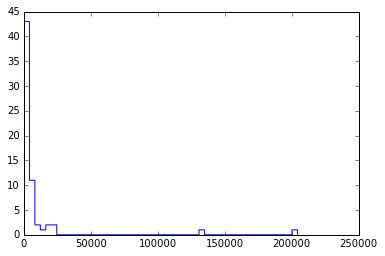

In [182]:
plt.hist(X_new.scores_, bins=50, histtype='step')

In [178]:
barf.describe()

,0
count,63.000000
mean,inf
std,NaN
min,0.219752
25%,0.711724
50%,1.129746
75%,1.964520
max,inf


In [164]:
for i in features_pulled:
    print census_numeric.columns.values[i]

tract
Estimate; Total
Estimate; Not Hispanic or Latino:
Estimate; Not Hispanic or Latino: - White alone
Estimate; Not Hispanic or Latino: - Black or African American alone
Estimate; Not Hispanic or Latino: - Asian alone
Estimate; Hispanic or Latino:
Estimate; Total: - No public assistance income
Estimate; Per capita income in the past 12 months (in 2014 Inflation-adjusted dollars)
Estimate; Total: - Renter occupied


#### Census Block Group Shapefiles

In [59]:
reader = sf.Reader('shapefiles/tl_2016_06_bg/tl_2016_06_bg.shp')

In [60]:
shapes = reader.shapes()

In the shapefile records: 
- 0: '06' is the State code
- 1: '031' is the County code (SD 073)
- 2: Tract
- 3: Block Group number 
- 4: GeoID 

can use reader.fields for a bit more info


In [694]:
bg_info = pd.DataFrame(reader.records())

In [765]:
# the San Diego county shapefile records
sdcounty = bg_info.loc[np.where((bg_info[1]=='073') & (bg_info[3]!='0'))[0]]
sdcounty_index = np.where((bg_info[1]=='073') & (bg_info[3]!='0'))[0]

#### Combine census + graffiti freq + shape file information

In [766]:
sdcounty.rename(columns={2: 'tract', 3: 'block_group'}, inplace=True)
sdcounty.loc[:,'tract'] = sdcounty.loc[:,'tract'].astype(int)
sdcounty.loc[:,'block_group'] = sdcounty.loc[:,'block_group'].astype(int)

In [767]:
census_combo = pd.merge(sdcounty, census_gfreq, on=['tract', 'block_group'], how='right')

/Users/kschles/anaconda/lib/python2.7/site-packages/pandas/indexes/base.py:917: DeprecationWarning:

unorderable dtypes; returning scalar but in the future this will be an error

/Users/kschles/anaconda/lib/python2.7/site-packages/pandas/indexes/base.py:917: DeprecationWarning:

unorderable dtypes; returning scalar but in the future this will be an error



In [699]:
"""
census_combo[['Estimate; Male:', 'Estimate; Female:','Estimate; Total: - White alone',
               'Estimate; Total: - Black or African American alone', 
               'Estimate; Total: - American Indian and Alaska Native alone', 
               'Estimate; Total: - Asian alone',
               'Estimate; Total: - Native Hawaiian and Other Pacific Islander alone',
               'Estimate; Total: - Some other race alone','Estimate; Total: - Two or more races:',
               'Estimate; Total: - Owner occupied']] = census_combo[['Estimate; Male:', 'Estimate; Female:',
                                                                     'Estimate; Total: - White alone',
                                                                     'Estimate; Total: - Black or African American alone', 
                                                                     'Estimate; Total: - American Indian and Alaska Native alone', 
                                                                     'Estimate; Total: - Asian alone',
                                                                     'Estimate; Total: - Native Hawaiian and Other Pacific Islander alone',
                                                                     'Estimate; Total: - Some other race alone','Estimate; Total: - Two or more races:',
                                                                     'Estimate; Total: - Owner occupied']].div(census_combo['Estimate; Total:'], axis=0)
                                                                     
"""                            

"\ncensus_combo[['Estimate; Male:', 'Estimate; Female:','Estimate; Total: - White alone',\n               'Estimate; Total: - Black or African American alone', \n               'Estimate; Total: - American Indian and Alaska Native alone', \n               'Estimate; Total: - Asian alone',\n               'Estimate; Total: - Native Hawaiian and Other Pacific Islander alone',\n               'Estimate; Total: - Some other race alone','Estimate; Total: - Two or more races:',\n               'Estimate; Total: - Owner occupied']] = census_combo[['Estimate; Male:', 'Estimate; Female:',\n                                                                     'Estimate; Total: - White alone',\n                                                                     'Estimate; Total: - Black or African American alone', \n                                                                     'Estimate; Total: - American Indian and Alaska Native alone', \n                                                  

In [138]:
import mpld3

In [139]:
mpld3.enable_notebook()

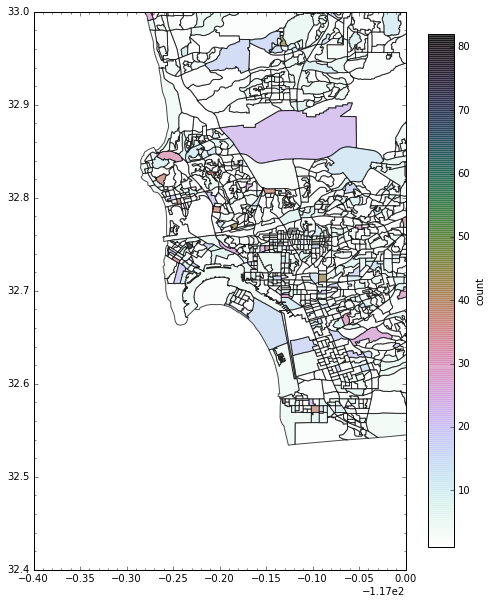

In [769]:
column_choice = 'count'
fig,ax = plt.subplots(1,1, figsize=(10,10))
patches = []
for i in range(0,len(sdcounty_index)): 
    barf = pd.DataFrame(shapes[sdcounty_index[i]].points)
    poly = plt.Polygon(barf[[0,1]], fc='none', ec='k', alpha=0.7)
    patches.append(poly)
    #plt.gca().add_patch(poly)

colors = census_combo[column_choice]
p = PatchCollection(patches, cmap='cubehelix_r', alpha=0.7)
p.set_array(np.array(colors))
p.set_clim([min(colors),max(colors)])
ax.add_collection(p)

plt.axis('scaled')
plt.minorticks_on()

plt.colorbar(p, fraction=0.046, pad=0.04, shrink=1.0, label=column_choice)

#plt.plot(lighting['Geolocation (Longitude)'], lighting['Geolocation (Latitude)'], 'k.')
#plt.plot(graffiti['Geolocation (Longitude)'], graffiti['Geolocation (Latitude)'], 'bs', mfc='none', mec='b')
#plt.plot(dump['Geolocation (Longitude)'], dump['Geolocation (Latitude)'], 'r.')

plt.ylim(32.4,33.0)
plt.xlim(-117.4,-117.0)

plt.show()
#mpld3.display()

In [141]:
mpld3.disable_notebook()

In [727]:
census_combo.replace({'-': np.nan}, regex=True, inplace=True)
census_combo.replace({'**': np.nan}, inplace=True)
census_combo.replace({'1,000,000+': '1000000'}, inplace=True)
census_combo.replace({'***': np.nan}, inplace=True)

### Playing with Feature Selection

e.g., what demographic information links up best with reports of graffiti?

Look at the correlation coefficient between different demographic information and the graffiti count

In [771]:
census_combo.corr(method='pearson')['count'].sort_values(ascending=False)

count                                                                                                                           1.000000
lighting_count                                                                                                                  0.245665
Estimate; With cash rent: - $650 to $699                                                                                        0.193789
Margin of Error; With cash rent: - $550 to $599                                                                                 0.173607
Estimate; With cash rent: - $550 to $599                                                                                        0.165335
Estimate; With cash rent:                                                                                                       0.164900
Margin of Error; With cash rent: - $650 to $699                                                                                 0.163479
Margin of Error; With cash rent: - $800 t

In [773]:
census_combo.replace({'-': None}, regex=True, inplace=True)
census_combo.replace({'**': None}, inplace=True)
census_combo.replace({'1,000,000+': '1000000'}, inplace=True)
census_combo.replace({'***': None}, inplace=True)

In [775]:
census_numeric = census_combo.select_dtypes(exclude = ['object'])

In [777]:
census_numeric.describe()

/Users/kschles/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning:

Invalid value encountered in percentile



,tract,block_group,8,9,count,lighting_count,Id2,RECORD CODES - Summary Level,RECORD CODES - Geographic Component,GEOGRAPHIC AREA CODES - State (FIPS),...,"Margin of Error; With cash rent: - $1,000 to $1,249","Estimate; With cash rent: - $1,250 to $1,499","Margin of Error; With cash rent: - $1,250 to $1,499","Estimate; With cash rent: - $1,500 to $1,999","Margin of Error; With cash rent: - $1,500 to $1,999","Estimate; With cash rent: - $2,000 or more","Margin of Error; With cash rent: - $2,000 or more",Estimate; No cash rent,Margin of Error; No cash rent,Id2_28
count,426.000000,426.000000,4.260000e+02,4.260000e+02,426.000000,209.000000,4.260000e+02,426.0,426.0,426.0,...,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,4.260000e+02
mean,6241.251174,2.192488,1.013116e+06,9.675734e+04,4.577465,3.665072,6.073006e+10,150.0,0.0,6.0,...,46.953052,44.652582,38.129108,57.772300,43.485915,35.166667,31.476526,7.727700,16.946009,6.073006e+10
std,4242.225962,1.180445,2.990392e+06,1.052612e+06,6.927514,4.889429,4.242224e+04,0.0,0.0,0.0,...,31.352983,56.306025,28.351819,87.944915,33.475906,81.363602,32.438839,14.083316,11.604032,4.242224e+04
min,100.000000,1.000000,7.013200e+04,0.000000e+00,1.000000,1.000000,6.073000e+10,150.0,0.0,6.0,...,8.000000,0.000000,7.000000,0.000000,6.000000,0.000000,8.000000,0.000000,6.000000,6.073000e+10
25%,2828.500000,1.000000,2.143482e+05,0.000000e+00,1.000000,NaN,6.073003e+10,150.0,0.0,6.0,...,19.000000,5.000000,12.000000,12.000000,18.000000,0.000000,12.000000,0.000000,12.000000,6.073003e+10
50%,5300.000000,2.000000,3.955360e+05,0.000000e+00,2.000000,NaN,6.073005e+10,150.0,0.0,6.0,...,44.500000,27.000000,30.000000,35.000000,35.000000,9.000000,14.000000,0.000000,12.000000,6.073005e+10
75%,8702.000000,3.000000,7.608318e+05,0.000000e+00,5.000000,NaN,6.073009e+10,150.0,0.0,6.0,...,66.000000,63.750000,54.750000,72.000000,61.000000,43.500000,42.750000,12.000000,17.750000,6.073009e+10
max,21500.000000,7.000000,4.052277e+07,2.010114e+07,82.000000,38.000000,6.073022e+10,150.0,0.0,6.0,...,156.000000,349.000000,183.000000,926.000000,240.000000,1060.000000,266.000000,166.000000,140.000000,6.073022e+10


In [782]:
for i in census_numeric.columns.values: 
    census_numeric.loc[np.where(np.isnan(census_numeric[i])==True)[0], i] = 0.0

In [853]:
X_new = SelectKBest(chi2, k=10).fit(census_numeric, census_numeric['count'])

In [854]:
[np.where(X_new.get_support()==True)[0]]

[array([ 0,  2,  3, 13, 16, 18, 20, 38, 40, 50])]

In [855]:
list(census_numeric.columns.values)[3]

9

In [812]:
X_new.get_support()

array([ True, False,  True,  True, False, False, False, False, False,
       False, False, False, False,  True, False, False,  True, False,
        True, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False,  True, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [806]:
dir(X_new)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__hash__',
 '__init__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_check_params',
 '_get_param_names',
 '_get_support_mask',
 'fit',
 'fit_transform',
 'get_params',
 'get_support',
 'inverse_transform',
 'k',
 'pvalues_',
 'score_func',
 'scores_',
 'set_params',
 'transform']

In [797]:
df.head()

,0,1,2,3,4,5,6,7,8,9
0,10013.0,404606.0,0.0,3624.0,3624.0,112.0,51.0,3512.0,3186.0,224.0
1,10103.0,397184.0,0.0,2691.0,2691.0,1077.0,537.0,1614.0,1409.0,124.0
2,10104.0,657709.0,0.0,1619.0,1619.0,808.0,532.0,811.0,711.0,85.0
3,10103.0,466481.0,0.0,2133.0,2133.0,322.0,164.0,1811.0,1479.0,296.0
4,10106.0,736442.0,0.0,2370.0,2370.0,290.0,201.0,2080.0,1803.0,277.0


In [795]:
np.shape(census_numeric)

(426, 159)

In [439]:
filenames='aff/block_groups/*with_ann.csv'
test=glob.glob(filenames)

In [504]:
geography_all = pd.read_csv('aff/block_groups/ACS_14_5YR_G001_with_ann.csv', header=1)
geo = geography_all[['Id', 'GEOGRAPHIC AREA CODES - Census Tract', 'GEOGRAPHIC AREA CODES - Block Group']]

In [509]:
geo.rename(columns={'GEOGRAPHIC AREA CODES - Census Tract': 'tract', 
                    'GEOGRAPHIC AREA CODES - Block Group': 'block_group'}, inplace=True)
#census_gfreq = pd.merge(graffiti_freq, census_trimmed, on=['tract', 'block_group'], how='left')

In [551]:
geo_gfreq1 = pd.merge(geo, graffiti_freq, on=['tract', 'block_group'], how='left')

In [552]:
geo_gfreq = geo_gfreq1.loc[np.where(geo_gfreq1['block_group']!=0)]

In [546]:
age = [1]
totals = [2]
race = [10]
income = [16, 17, 18, 19]
propvals = [20, 25, 28]

In [685]:
i = 10
temp = pd.read_csv(test[i], header=1, low_memory=False)

print test[i] 
temp.columns.values

aff/block_groups/ACS_14_5YR_B03002_with_ann.csv


array(['Id', 'Id2', 'Geography', 'Estimate; Total:',
       'Margin of Error; Total:', 'Estimate; Not Hispanic or Latino:',
       'Margin of Error; Not Hispanic or Latino:',
       'Estimate; Not Hispanic or Latino: - White alone',
       'Margin of Error; Not Hispanic or Latino: - White alone',
       'Estimate; Not Hispanic or Latino: - Black or African American alone',
       'Margin of Error; Not Hispanic or Latino: - Black or African American alone',
       'Estimate; Not Hispanic or Latino: - American Indian and Alaska Native alone',
       'Margin of Error; Not Hispanic or Latino: - American Indian and Alaska Native alone',
       'Estimate; Not Hispanic or Latino: - Asian alone',
       'Margin of Error; Not Hispanic or Latino: - Asian alone',
       'Estimate; Not Hispanic or Latino: - Native Hawaiian and Other Pacific Islander alone',
       'Margin of Error; Not Hispanic or Latino: - Native Hawaiian and Other Pacific Islander alone',
       'Estimate; Not Hispanic or Latino

In [686]:
yak = pd.merge(geo_gfreq, temp, on='Id', how='left')

yak.replace({'-': np.nan}, regex=True, inplace=True)
yak.replace({'**': np.nan}, inplace=True)
yak.replace({'1,000,000+': '1000000'}, inplace=True)
yak.replace({'***': np.nan}, inplace=True)


lister = list(yak.select_dtypes(include=['object']).columns.values)

for i in lister: 
    if ((i!='Id') & (i!='Geography')): 
        yak[i] = yak[i].astype(float)


In [705]:
census_combo.corr(method='pearson')['count'].sort_values(ascending=False)[20:50]

Estimate; Total: - $10,000 to $14,999                                      0.161124
Estimate; Nonfamily households: - Householder living alone                 0.159963
Estimate; Male: - 30 to 34 years                                           0.159555
Estimate; Total:_25                                                        0.159405
Estimate; Total: - Renter occupied                                         0.159405
Estimate; Total: - Renter occupied_20                                      0.159405
Estimate; Total:_25                                                        0.159405
Margin of Error; Total: - $10,000 to $14,999_16                            0.152858
Margin of Error; Total: - $10,000 to $14,999                               0.152858
Margin of Error; Total: - Built 1939 or earlier                            0.152655
Margin of Error; Nonfamily households:                                     0.144250
Margin of Error; With cash rent:                                           0

In [683]:
from pandas.tools.plotting import scatter_matrix

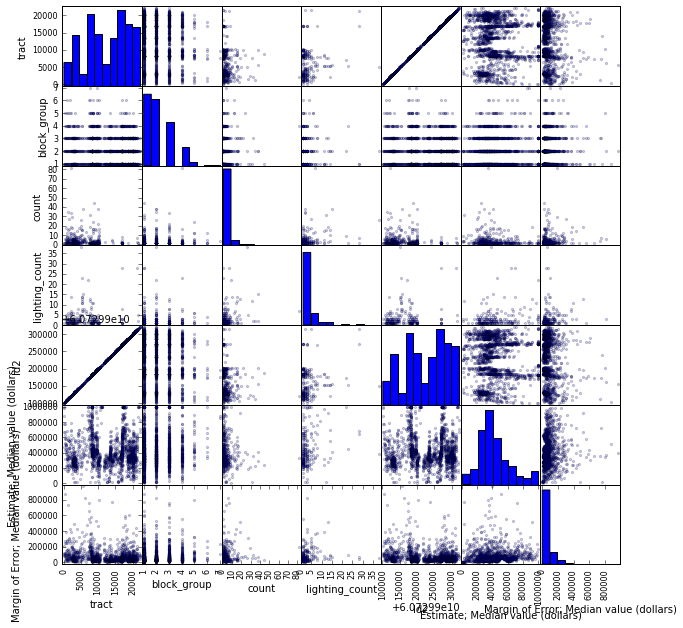

In [684]:
fig, ax = plt.subplots(figsize=(10, 10))
scatter_matrix(yak, alpha=0.2, diagonal='hist', ax=ax);


In [226]:
from minepy import MINE
from scipy.stats.stats import pearsonr

In [268]:
from sklearn.preprocessing import StandardScaler

In [351]:
census_numeric = census_combo.select_dtypes(exclude=['object'])

In [355]:
census_numeric.loc[np.where(np.isnan(census_numeric['lighting_count'])==True)[0], 'lighting_count'] = 0.

/Users/kschles/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [356]:
X = StandardScaler().fit_transform(census_numeric)

In [357]:
col_info = pd.DataFrame(list(census_numeric.columns.values))

In [358]:
col_info.rename(columns={0: 'colname'}, inplace=True)

In [359]:
col_info['coltype'] = list(census_numeric.dtypes)

In [360]:
col_info['mic_score'] = None
col_info['pearson_cc'] = None
col_info['pearson_pv'] = None

for i in range(0,len(col_info)-1): 
    if ((col_info.loc[i, 'coltype']!='object')):
        if (('Margin of Error' not in str(col_info.loc[i, 'colname'])) 
            & ('Id' not in str(col_info.loc[i, 'colname']))):  
            #m.compute_score(census_combo['count'], 
            #                census_combo[col_info.loc[i, 'colname']])
            m.compute_score(X[:,4], X[:,i])
            col_info.loc[i, 'mic_score'] = m.mic()
            
            #temp = pearsonr(census_combo['count'], census_combo[col_info.loc[i, 'colname']].astype(float))
            temp = pearsonr(X[:,4], X[:,i].astype(float))
            col_info.loc[i, 'pearson_cc'] = temp[0]
            col_info.loc[i, 'pearson_pv'] = temp[1]
            

In [325]:
from scipy.stats import linregress

puke = col_info[['mic_score', 'pearson_cc']].dropna()
outie = linregress(puke['mic_score'], puke['pearson_cc'])

LinregressResult(slope=0.72910464646487205, intercept=-0.070909226123648306, rvalue=0.56654621626628054, pvalue=1.2093239152540223e-23, stderr=0.065767427346673762)

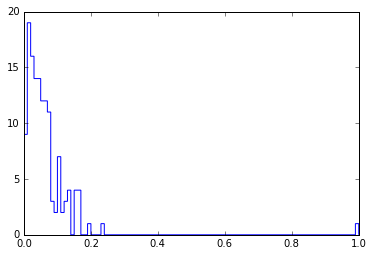

In [524]:
test = plt.hist(col_info['pearson_cc'], bins=100, range=[0,1], histtype='step')

In [362]:
col_info.sort_values(by='pearson_cc', ascending=False)

,colname,coltype,mic_score,pearson_cc,pearson_pv
4,count,int64,0.999602,1,0
5,lighting_count,float64,0.0694648,0.236242,8.15417e-07
476,Estimate; With cash rent: - $650 to $699,int64,0.124453,0.193789,5.66787e-05
211,Estimate; Nonfamily households:,int64,0.186164,0.166792,0.000546864
472,Estimate; With cash rent: - $550 to $599,int64,0.0888884,0.165335,0.000612417
450,Estimate; With cash rent:,int64,0.179539,0.1649,0.000633348
341,"Estimate; Total: - $10,000 to $14,999",int64,0.105601,0.161124,0.000844967
213,Estimate; Nonfamily households: - Householder ...,int64,0.136493,0.159963,0.000922167
29,Estimate; Male: - 30 to 34 years,int64,0.128211,0.159555,0.000950807
448,Estimate; Total:_25,int64,0.182261,0.159405,0.000961556


In [375]:
from sklearn.feature_selection import SelectPercentile, SelectKBest, chi2

In [388]:
col_info.loc[501]

colname       Estimate; Total: - $10,000 to $14,999_26
coltype                                          int64
mic_score                                    0.0485313
pearson_cc                                   0.0535533
pearson_pv                                    0.270083
Name: 501, dtype: object

In [733]:
X_new = SelectKBest(chi2, k=1).fit_transform(census_numeric, census_numeric['count'])

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [725]:
from sklearn.cluster import DBSCAN, KMeans
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

In [730]:
census_numeric = census_combo.select_dtypes(exclude = ['object'])

In [741]:
len(np.where(np.isnan(census_numeric)==True)[0]), len(np.where(np.isnan(census_numeric)==True)[1])

(643, 643)

In [748]:
census_numeric.replace({np.nan: None}, regex=True, inplace=True)

/Users/kschles/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:3362: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [751]:
census_numeric

,tract,block_group,8,9,11,count,lighting_count,Id2,Estimate; Total:,Margin of Error; Total:,...,"Margin of Error; With cash rent: - $1,000 to $1,249_25","Estimate; With cash rent: - $1,250 to $1,499_25","Margin of Error; With cash rent: - $1,250 to $1,499_25","Estimate; With cash rent: - $1,500 to $1,999_25","Margin of Error; With cash rent: - $1,500 to $1,999_25","Estimate; With cash rent: - $2,000 or more_25","Margin of Error; With cash rent: - $2,000 or more_25",Estimate; No cash rent_25,Margin of Error; No cash rent_25,Id2_28
0,10013,2,404606,0,NaN,4,1.0,60730100132,3624,447,...,63,9,15,9,14,9,14,27,29,60730100132
1,10103,3,397184,0,NaN,22,NaN,60730101033,2691,556,...,61,38,57,91,56,0,12,13,21,60730101033
2,10104,2,657709,0,NaN,38,2.0,60730101042,1619,387,...,12,10,16,81,45,0,12,0,12,60730101042
3,10103,2,466481,0,NaN,3,NaN,60730101032,2133,631,...,64,53,49,108,67,5,9,0,12,60730101032
4,10106,1,736442,0,NaN,10,NaN,60730101061,2370,580,...,66,0,12,42,29,0,12,0,12,60730101061
5,4100,4,847384,0,NaN,1,2.0,60730041004,1905,513,...,107,76,74,14,22,0,12,0,12,60730041004
6,4200,4,474314,0,NaN,2,NaN,60730042004,813,418,...,97,0,12,0,12,12,21,0,12,60730042004
7,5400,3,74090,0,NaN,4,5.0,60730054003,945,266,...,12,99,89,237,110,74,78,23,36,60730054003
8,6100,2,448379,0,NaN,6,3.0,60730061002,546,175,...,21,47,33,63,48,0,12,0,12,60730061002
9,7200,2,1684279,709604,NaN,9,22.0,60730072002,3142,320,...,23,0,12,0,12,104,64,9,14,60730072002


In [752]:
X = StandardScaler().fit_transform(census_numeric[['count', 'lighting_count']])

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

(-117.5, -116.7)

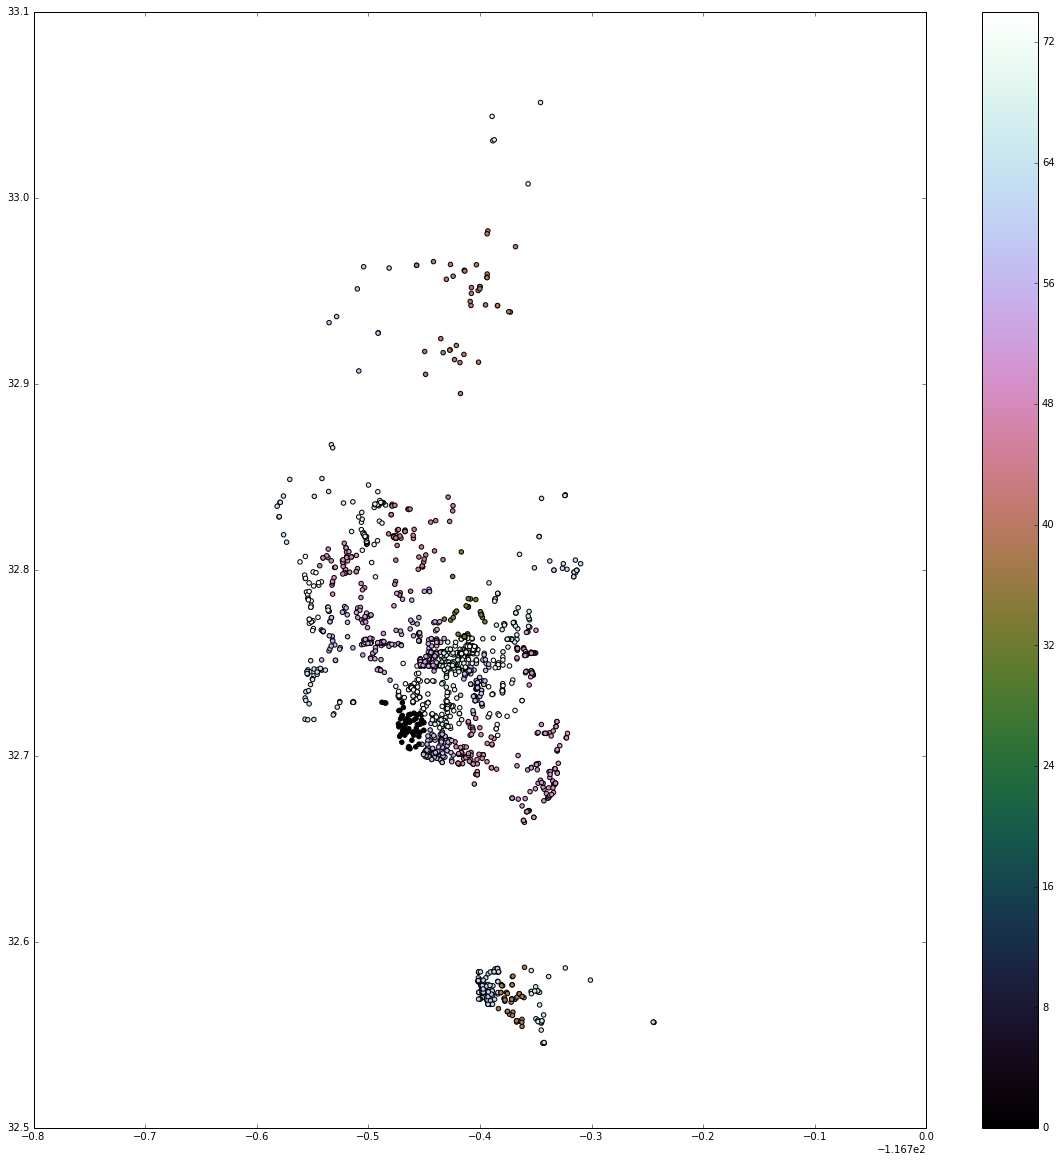

In [221]:
X = graffiti[['Geolocation (Longitude)', 'Geolocation (Latitude)']]
X = StandardScaler().fit_transform(graffiti[['Geolocation (Longitude)', 'Geolocation (Latitude)']])
random_state = 170
# Incorrect number of clusters
y_pred = KMeans(n_clusters=75, random_state=random_state).fit_predict(X)

plt.subplots(1,1, figsize=(20,20))
plt.scatter(X['Geolocation (Longitude)'], X['Geolocation (Latitude)'], c=y_pred, cmap='cubehelix')
plt.colorbar()

plt.ylim(32.5,33.1)
plt.xlim(-117.5,-116.7)

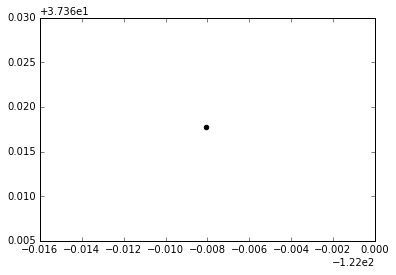

In [232]:
indexer = np.where(y_pred==51)[0]
plt.scatter(X.loc[indexer, 'Geolocation (Longitude)'], X.loc[indexer, 'Geolocation (Latitude)'], c=y_pred[indexer],
            cmap='cubehelix')



In [196]:
# Compute DBSCAN
db = DBSCAN(eps=0.1, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

In [197]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print n_clusters_

1


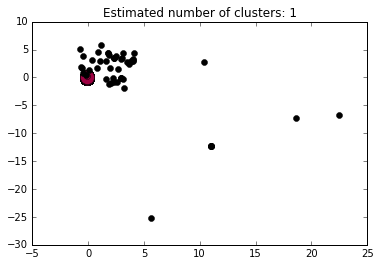

In [198]:
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()


(-117.5, -116.7)

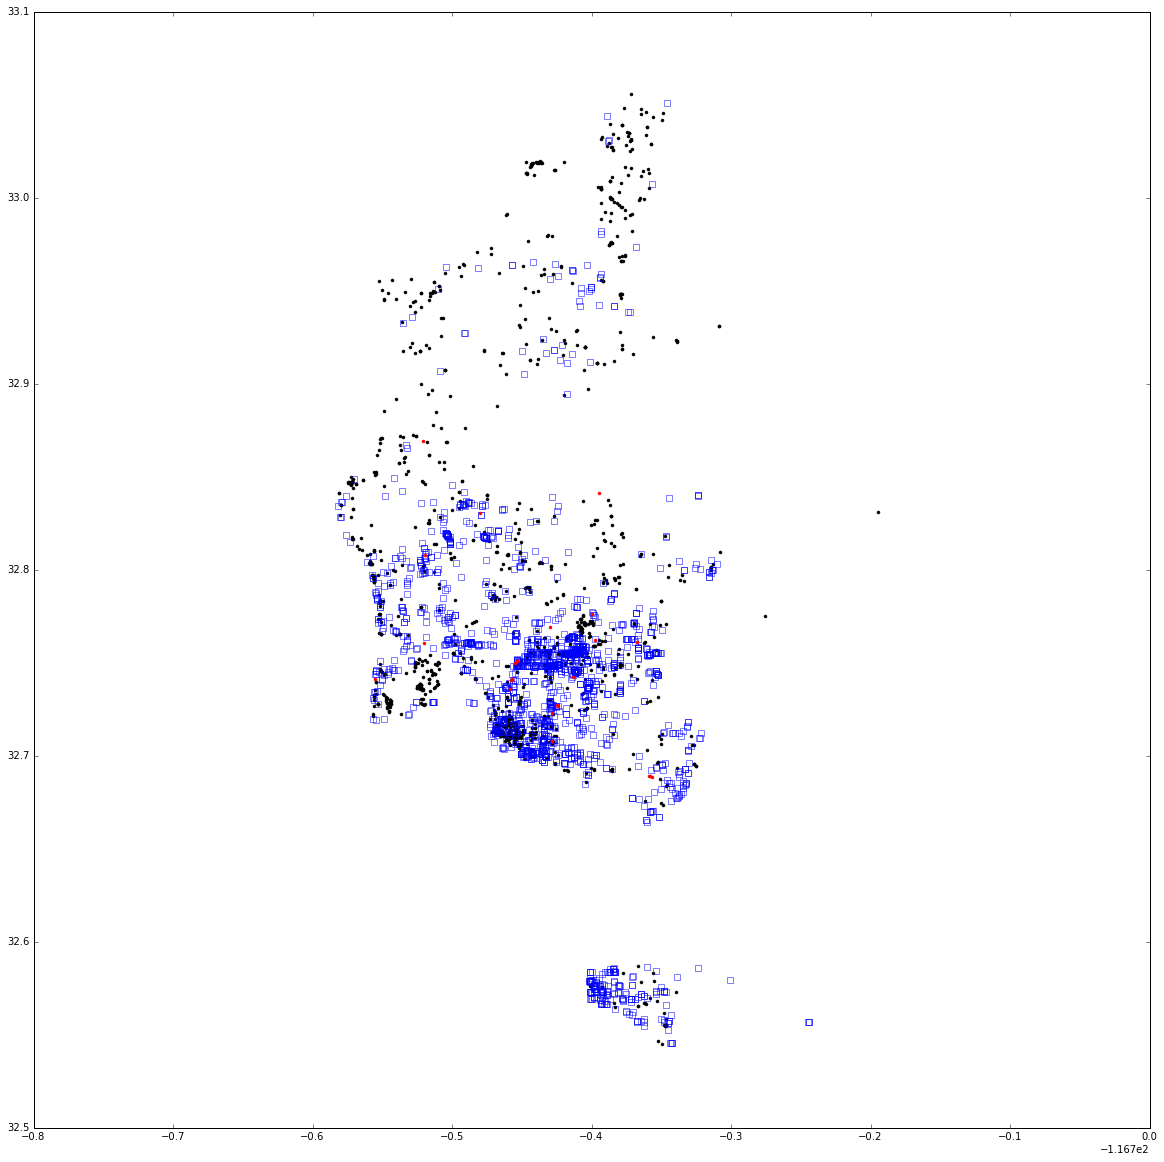

In [175]:
fig = plt.subplots(1,1, figsize=(20,20))

plt.plot(lighting['Geolocation (Longitude)'], lighting['Geolocation (Latitude)'], 'k.')
plt.plot(graffiti['Geolocation (Longitude)'], graffiti['Geolocation (Latitude)'], 'bs', mfc='none', mec='b')
plt.plot(dump['Geolocation (Longitude)'], dump['Geolocation (Latitude)'], 'r.')

plt.ylim(32.5,33.1)
plt.xlim(-117.5,-116.7)

In [55]:
dump[['block_group', 'tract', 'geoid']]

,block_group,tract,geoid
0,2,004000,060730040002
1,2,002001,060730020012
2,3,003201,060730032013
3,2,007301,060730073012
4,3,000300,060730003003
5,2,003201,060730032012
6,3,000600,060730006003
7,3,003201,060730032013
8,3,008506,060730085063
9,4,004200,060730042004


CensusGeocode

In [21]:
cg = CensusGeocode()

In [9]:
graffiti.loc[0,['Geolocation (Longitude)', 'Geolocation (Latitude)']].astype(float)

Geolocation (Longitude)   -117.106023
Geolocation (Latitude)      32.695569
Name: 0, dtype: float64

In [233]:
cg = CensusGeocode()

cg.coordinates(x=-76, y=41)
#cg.onelineaddress('1600 Pennsylvania Avenue, Washington, DC')
#cg.address('1600 Pennsylvania Avenue', city='Washington', state='DC', zipcode='22052')

ValueError: No JSON object could be decoded

In [144]:
graffiti['block']=None
graffiti['tract']=None
graffiti['geoid']=None

for i in range(0,10): 
    if (graffiti.loc[i,'Geolocation (Longitude)']!=0.0) :
        temp = cg.coordinates(x=graffiti.loc[i,'Geolocation (Longitude)'], 
                              y=graffiti.loc[i, 'Geolocation (Latitude)'])[0]['2010 Census Blocks'][0]
        graffiti.loc[i, 'block'] = temp['BLOCK']
        graffiti.loc[i, 'tract'] = temp['TRACT']
        graffiti.loc[i, 'geoid'] = temp['GEOID']

ValueError: No JSON object could be decoded

### Census information 

factfinder.census.gov

Organised by BLOCK

In [23]:
filenames='aff/blocks/D*with_ann.csv'
test=glob.glob(filenames)

In [24]:
for i in range(0,len(test)): 
    temp = pd.read_csv(test[i], header=1, low_memory=False)
    print i, i, i 
    if (i==0): 
        census = temp.copy()
    if (i!=0): 
        combo = pd.merge(census, temp, on='Id', how='left', suffixes=('', '_' + str(i)))
        census = combo.copy()
        census.reset_index(drop=True)

0 0 0
1 1 1
2 2 2
3 3 3
4 4 4
5 5 5
6 6 6
7 7 7
8 8 8
9 9 9
10 10 10
11 11 11
12 12 12
13 13 13
14 14 14
15 15 15
16 16 16
17 17 17
18 18 18
19 19 19
20 20 20
21 21 21
22 22 22
23 23 23


In [26]:
census_trimmed = census[['Id', 'Id2', 'Geography', 'Total:', 'Owner occupied','Renter occupied',
                         'For seasonal, recreational, or occasional use','For migrant workers', 
                         'Other vacant','Householder who is White alone',
                         'Householder who is Black or African American alone',
                         'Householder who is American Indian and Alaska Native alone',
                         'Householder who is Asian alone',
                         'Householder who is Native Hawaiian and Other Pacific Islander alone',
                         'Householder who is Some other race alone','Householder who is Two or more races', 
                         'GEOGRAPHIC AREA CODES - Census Tract','GEOGRAPHIC AREA CODES - Block Group',
                         'GEOGRAPHIC AREA CODES - Block','GEOGRAPHIC AREA CODES - Urban Area',
                         'GEOGRAPHIC AREA CODES - Urban Area Type','GEOGRAPHIC AREA CODES - Urban/Rural',
                         'AREA CHARACTERISTICS - Population Count (100%)',
                         'AREA CHARACTERISTICS - Housing Unit Count (100%)',
                         'AREA CHARACTERISTICS - Internal Point (Latitude)',
                         'AREA CHARACTERISTICS - Internal Point (Longitude)',
                         'Total:_4', 'Occupied', 'Vacant','Population of one race:',
                         'Population of one race: - White alone',
                         'Population of one race: - Black or African American alone',
                         'Population of one race: - American Indian and Alaska Native alone',
                         'Population of one race: - Asian alone',
                         'Population of one race: - Native Hawaiian and Other Pacific Islander alone',
                         'Population of one race: - Some Other Race alone','Two or More Races:',
                         'Two or More Races: - Population of three races:',
                         'Two or More Races: - Population of four races:',
                         'Two or More Races: - Population of five races:',
                         'Two or More Races: - Population of six races:','Male:',
                         'Male: - Under 5 years', 'Male: - 5 to 9 years','Male: - 10 to 14 years', 
                         'Male: - 15 to 17 years','Male: - 18 and 19 years', 'Male: - 20 years', 
                         'Male: - 21 years','Male: - 22 to 24 years', 'Male: - 25 to 29 years',
                         'Male: - 30 to 34 years', 'Male: - 35 to 39 years','Male: - 40 to 44 years', 
                         'Male: - 45 to 49 years','Male: - 50 to 54 years', 'Male: - 55 to 59 years',
                         'Male: - 60 and 61 years', 'Male: - 62 to 64 years','Male: - 65 and 66 years', 
                         'Male: - 67 to 69 years','Male: - 70 to 74 years', 'Male: - 75 to 79 years',
                         'Male: - 80 to 84 years', 'Male: - 85 years and over', 'Female:','Female: - Under 5 years', 
                         'Female: - 5 to 9 years','Female: - 10 to 14 years', 'Female: - 15 to 17 years',
                         'Female: - 18 and 19 years', 'Female: - 20 years','Female: - 21 years', 
                         'Female: - 22 to 24 years','Female: - 25 to 29 years', 'Female: - 30 to 34 years',
                         'Female: - 35 to 39 years', 'Female: - 40 to 44 years','Female: - 45 to 49 years', 
                         'Female: - 50 to 54 years','Female: - 55 to 59 years', 'Female: - 60 and 61 years',
                         'Female: - 62 to 64 years', 'Female: - 65 and 66 years','Female: - 67 to 69 years', 
                         'Female: - 70 to 74 years','Female: - 75 to 79 years', 'Female: - 80 to 84 years',
                         'Female: - 85 years and over', 'Id2_12', 'Geography_12','Median age -- - Both sexes', 
                         'Median age -- - Male','Median age -- - Female', 'Total:_13','Under 18 years', 
                         '18 years and over', 'Id2_14', 'Geography_14','Total:_14', 'Family households:',
                         'Family households: - Husband-wife family','Family households: - Other family:',
                         'Family households: - Other family: - Male householder, no wife present',
                         'Family households: - Other family: - Female householder, no husband present',
                         'Nonfamily households:','Nonfamily households: - Householder living alone',
                         'Nonfamily households: - Householder not living alone', 'Urban:', 
                         'Urban: - Inside urbanized areas','Urban: - Inside urban clusters', 
                         'Rural','Not defined for this file','Total:_19','White alone', 
                         'Black or African American alone','American Indian and Alaska Native alone', 
                         'Asian alone','Native Hawaiian and Other Pacific Islander alone','Some Other Race alone', 
                         'Two or More Races', 'Id2_20','Geography_20', 'Total:_20', 'Not Hispanic or Latino',
                         'Hispanic or Latino', 'Id2_21', 'Geography_21','Number; TENURE - Occupied housing units',
                         'Percent; TENURE - Occupied housing units',
                         'Number; TENURE - Occupied housing units - Owned with a mortgage or loan',
                         'Percent; TENURE - Occupied housing units - Owned with a mortgage or loan',
                         'Number; TENURE - Occupied housing units - Owned free and clear',
                         'Percent; TENURE - Occupied housing units - Owned free and clear',
                         'Number; TENURE - Occupied housing units - Renter occupied',
                         'Percent; TENURE - Occupied housing units - Renter occupied',
                         'Number; HOUSEHOLD POPULATION - Occupied housing units',
                         'Percent; HOUSEHOLD POPULATION - Occupied housing units',
                         'Number; HOUSEHOLD POPULATION - Occupied housing units - Owner-occupied housing units',
                         'Percent; HOUSEHOLD POPULATION - Occupied housing units - Owner-occupied housing units',
                         'Number; HOUSEHOLD POPULATION - Occupied housing units - Renter-occupied housing units',
                         'Percent; HOUSEHOLD POPULATION - Occupied housing units - Renter-occupied housing units']]

In [31]:
census_trimmed[['Id', 'Id2', 'Median age -- - Male', 'GEOGRAPHIC AREA CODES - Block']]

,Id,Id2,Median age -- - Male,GEOGRAPHIC AREA CODES - Block
0,1000000US060730001001000,60730001001000,49.4,1000
1,1000000US060730001001001,60730001001001,50.5,1001
2,1000000US060730001001002,60730001001002,52.5,1002
3,1000000US060730001001003,60730001001003,49.5,1003
4,1000000US060730001001004,60730001001004,58.5,1004
5,1000000US060730001001005,60730001001005,55.5,1005
6,1000000US060730001001006,60730001001006,49.2,1006
7,1000000US060730001001007,60730001001007,47.5,1007
8,1000000US060730001001008,60730001001008,54.3,1008
9,1000000US060730001001009,60730001001009,59.0,1009


In [108]:
requests[['block', 'tract', 'geoid']]

,block,tract,geoid
0,1009,017044,060730170441009
1,None,None,None
2,1004,008347,060730083471004
3,None,None,None
4,None,None,None
5,None,None,None
6,None,None,None
7,None,None,None
8,None,None,None
9,1004,008347,060730083471004


In [101]:
temp = cg.coordinates(x=requests.loc[0:5, 'long'], y=requests.loc[0:5, 'lat'])[0]['2010 Census Blocks'][0]['BLOCK']

In [104]:
cg.coordinates(x=requests.loc[0:5, 'long'], y=requests.loc[0:5, 'lat'])

1

In [116]:
census.loc[0:10, ['Id', 'Id2', 'Geography', 'GEOGRAPHIC AREA CODES - Block', 'GEOGRAPHIC AREA CODES - Urban/Rural']]

,Id,Id2,Geography,GEOGRAPHIC AREA CODES - Block,GEOGRAPHIC AREA CODES - Urban/Rural
0,1000000US060730001001000,60730001001000,"Block 1000, Block Group 1, Census Tract 1, San...",1000,
1,1000000US060730001001001,60730001001001,"Block 1001, Block Group 1, Census Tract 1, San...",1001,
2,1000000US060730001001002,60730001001002,"Block 1002, Block Group 1, Census Tract 1, San...",1002,
3,1000000US060730001001003,60730001001003,"Block 1003, Block Group 1, Census Tract 1, San...",1003,
4,1000000US060730001001004,60730001001004,"Block 1004, Block Group 1, Census Tract 1, San...",1004,
5,1000000US060730001001005,60730001001005,"Block 1005, Block Group 1, Census Tract 1, San...",1005,
6,1000000US060730001001006,60730001001006,"Block 1006, Block Group 1, Census Tract 1, San...",1006,
7,1000000US060730001001007,60730001001007,"Block 1007, Block Group 1, Census Tract 1, San...",1007,
8,1000000US060730001001008,60730001001008,"Block 1008, Block Group 1, Census Tract 1, San...",1008,
9,1000000US060730001001009,60730001001009,"Block 1009, Block Group 1, Census Tract 1, San...",1009,


In [115]:
census.columns.values

array(['Id', 'Id2', 'Geography', 'Total:', 'Owner occupied',
       'Renter occupied', 'Id2_1', 'Geography_1', 'Total:_1', 'For rent',
       'For sale only', 'Rented or sold, not occupied',
       'For seasonal, recreational, or occasional use',
       'For migrant workers', 'Other vacant', 'Id2_2', 'Geography_2',
       'Total:_2', 'Householder who is White alone',
       'Householder who is Black or African American alone',
       'Householder who is American Indian and Alaska Native alone',
       'Householder who is Asian alone',
       'Householder who is Native Hawaiian and Other Pacific Islander alone',
       'Householder who is Some other race alone',
       'Householder who is Two or more races', 'Id2_3', 'Geography_3',
       'RECORD CODES - File Identification',
       'RECORD CODES - State/US-Abbreviation (USPS)',
       'RECORD CODES - Summary Level',
       'RECORD CODES - Geographic Component',
       'RECORD CODES - Characteristic Iteration',
       'RECORD CODES - Ch

In [62]:
census.loc[0:10, ['Id', 'Id2', 'Geography', 'GEOGRAPHIC AREA CODES - Block Group', 'GEOGRAPHIC AREA CODES - Census Tract']]

,Id,Id2,Geography,GEOGRAPHIC AREA CODES - Block Group,GEOGRAPHIC AREA CODES - Census Tract
0,1500000US060730001001,60730001001,"Block Group 1, Census Tract 1, San Diego Count...",1,100
1,1500000US060730001002,60730001002,"Block Group 2, Census Tract 1, San Diego Count...",2,100
2,1500000US060730002011,60730002011,"Block Group 1, Census Tract 2.01, San Diego Co...",1,201
3,1500000US060730002021,60730002021,"Block Group 1, Census Tract 2.02, San Diego Co...",1,202
4,1500000US060730002022,60730002022,"Block Group 2, Census Tract 2.02, San Diego Co...",2,202
5,1500000US060730002023,60730002023,"Block Group 3, Census Tract 2.02, San Diego Co...",3,202
6,1500000US060730003001,60730003001,"Block Group 1, Census Tract 3, San Diego Count...",1,300
7,1500000US060730003002,60730003002,"Block Group 2, Census Tract 3, San Diego Count...",2,300
8,1500000US060730003003,60730003003,"Block Group 3, Census Tract 3, San Diego Count...",3,300
9,1500000US060730003004,60730003004,"Block Group 4, Census Tract 3, San Diego Count...",4,300


In [29]:
census.columns.values

array(['Id', 'Id2', 'Geography', 'Estimate; Total:',
       'Margin of Error; Total:', 'Estimate; Male:',
       'Margin of Error; Male:', 'Estimate; Male: - Under 5 years',
       'Margin of Error; Male: - Under 5 years',
       'Estimate; Male: - 5 to 9 years',
       'Margin of Error; Male: - 5 to 9 years',
       'Estimate; Male: - 10 to 14 years',
       'Margin of Error; Male: - 10 to 14 years',
       'Estimate; Male: - 15 to 17 years',
       'Margin of Error; Male: - 15 to 17 years',
       'Estimate; Male: - 18 and 19 years',
       'Margin of Error; Male: - 18 and 19 years',
       'Estimate; Male: - 20 years', 'Margin of Error; Male: - 20 years',
       'Estimate; Male: - 21 years', 'Margin of Error; Male: - 21 years',
       'Estimate; Male: - 22 to 24 years',
       'Margin of Error; Male: - 22 to 24 years',
       'Estimate; Male: - 25 to 29 years',
       'Margin of Error; Male: - 25 to 29 years',
       'Estimate; Male: - 30 to 34 years',
       'Margin of Error; Male:

### Census Roads Shapefiles

In [556]:
!pip install stateplane

    100% |████████████████████████████████| 378kB 1.4MB/s 
    100% |████████████████████████████████| 18.2MB 29kB/s 
    100% |████████████████████████████████| 4.4MB 145kB/s 
    100% |████████████████████████████████| 2.2MB 260kB/s 
  Running setup.py bdist_wheel for stateplane ... - \ | / - \ done
  Stored in directory: /Users/kschles/Library/Caches/pip/wheels/68/3e/91/f1f709294f73b2c6cd6a34defc1675c34f45d595cfefd65d1f
  Running setup.py bdist_wheel for pyproj ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - 

In [557]:
import stateplane

In [422]:
reader_roads = shapefile.Reader('shapefiles/CITY.ROADS_ALL_datasd/CITY_ROADS_ALL.shp')

In [562]:
reader_roads = shapefile.Reader('/Users/kschles/Downloads/Roads_All/ROADS_ALL.shp')

In [554]:
shapes_roads = reader_roads.shapes()

In [597]:
road_details = reader_roads.records()

In [555]:
shapes_roads[0].bbox

[6314380.855000004, 1977268.0, 6314527.0, 1977572.0]

In [658]:
stateplane.to_latlon(6314380.855000004, 1977268.0, epsg='2230')

(36.03783582031992, -66.56936903600409)

In [661]:
reader_roads.fields[27]

['NAD83N', 'N', 19, 8]

In [662]:
road_details[i][26], road_details[i][27]

(1977572.0, 6314527.0)

In [657]:
reader_roads.fields

[('DeletionFlag', 'C', 1, 0),
 ['FNODE', 'N', 10, 0],
 ['TNODE', 'N', 10, 0],
 ['LENGTH', 'N', 19, 8],
 ['ROADSEGID', 'N', 10, 0],
 ['POSTID', 'C', 20, 0],
 ['POSTDATE', 'D', 8, 0],
 ['ROADID', 'N', 10, 0],
 ['RIGHTWAY', 'N', 5, 0],
 ['ADDSEGDT', 'D', 8, 0],
 ['SEGSTAT', 'C', 1, 0],
 ['DEDSTAT', 'C', 1, 0],
 ['FUNCLASS', 'C', 1, 0],
 ['ONEWAY', 'C', 1, 0],
 ['SUBDIVID', 'N', 10, 0],
 ['SEGCLASS', 'C', 1, 0],
 ['LJURISDIC', 'C', 2, 0],
 ['LLOWADDR', 'N', 10, 0],
 ['LHIGHADDR', 'N', 10, 0],
 ['RJURISDIC', 'C', 2, 0],
 ['RLOWADDR', 'N', 10, 0],
 ['RHIGHADDR', 'N', 10, 0],
 ['LMIXADDR', 'C', 1, 0],
 ['RMIXADDR', 'C', 1, 0],
 ['PENDING', 'C', 1, 0],
 ['ABLOADDR', 'N', 10, 0],
 ['ABHIADDR', 'N', 10, 0],
 ['NAD83N', 'N', 19, 8],
 ['NAD83E', 'N', 19, 8],
 ['SPEED', 'N', 5, 0],
 ['L_ZIP', 'N', 10, 0],
 ['R_ZIP', 'N', 10, 0],
 ['LPSJUR', 'C', 2, 0],
 ['RPSJUR', 'C', 2, 0],
 ['CARTO', 'C', 1, 0],
 ['OBMH', 'C', 1, 0],
 ['FIREDRIV', 'C', 1, 0],
 ['L_BLOCK', 'N', 10, 0],
 ['R_BLOCK', 'N', 10, 0],
 

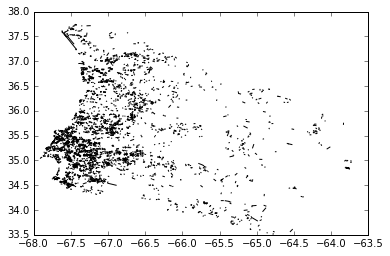

In [666]:
for i in range(0,5000): 
    start = stateplane.to_latlon(road_details[i][45], road_details[i][46], epsg='2230')
    end = stateplane.to_latlon(road_details[i][49], road_details[i][50], epsg='2230')
    
    plt.plot([start[1], end[1]], [start[0], end[0]], 'k-')
    #plt.xlim(-70, -69.5)
    #plt.ylim(11,11.5)

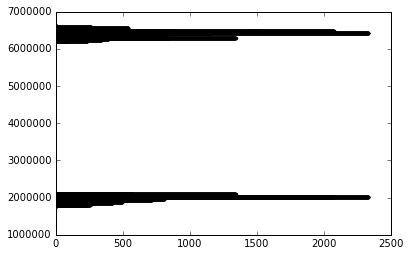

In [500]:
for i in range(0,1000): 
    plt.plot(shapes_roads[i].points, 'k.')

In [491]:
reader_roads.fields

[('DeletionFlag', 'C', 1, 0),
 ['OBJECTID', 'N', 10, 0],
 ['FNODE', 'N', 10, 0],
 ['TNODE', 'N', 10, 0],
 ['LENGTH', 'F', 19, 11],
 ['ROADSEGID', 'N', 10, 0],
 ['POSTID', 'C', 20, 0],
 ['POSTDATE', 'C', 20, 0],
 ['ROADID', 'N', 10, 0],
 ['RIGHTWAY', 'N', 5, 0],
 ['ADDSEGDT', 'C', 20, 0],
 ['SEGSTAT', 'C', 1, 0],
 ['DEDSTAT', 'C', 1, 0],
 ['FUNCLASS', 'C', 1, 0],
 ['ONEWAY', 'C', 1, 0],
 ['SUBDIVID', 'N', 10, 0],
 ['SEGCLASS', 'C', 1, 0],
 ['LJURISDIC', 'C', 2, 0],
 ['LLOWADDR', 'N', 10, 0],
 ['LHIGHADDR', 'N', 10, 0],
 ['RJURISDIC', 'C', 2, 0],
 ['RLOWADDR', 'N', 10, 0],
 ['RHIGHADDR', 'N', 10, 0],
 ['LMIXADDR', 'C', 1, 0],
 ['RMIXADDR', 'C', 1, 0],
 ['PENDING', 'C', 1, 0],
 ['ABLOADDR', 'N', 10, 0],
 ['ABHIADDR', 'N', 10, 0],
 ['NAD83N', 'F', 19, 11],
 ['NAD83E', 'F', 19, 11],
 ['SPEED', 'N', 5, 0],
 ['L_ZIP', 'N', 10, 0],
 ['R_ZIP', 'N', 10, 0],
 ['LPSJUR', 'C', 2, 0],
 ['RPSJUR', 'C', 2, 0],
 ['CARTO', 'C', 1, 0],
 ['OBMH', 'C', 1, 0],
 ['FIREDRIV', 'C', 1, 0],
 ['L_BLOCK', 'N', 10,

### Census block Shapefiles

http://rdw.sandag.org/Account/gisdtview?dir=Census

In [42]:
reader = shapefile.Reader('shapefiles/CENSUS_BLOCKS_2010/CENSUS_BLOCKS_2010.shp')

### Census Block Group Shapefiles

In [243]:
reader = shapefile.Reader('shapefiles/tl_2016_06_bg/tl_2016_06_bg.shp')

In [244]:
shapes = reader.shapes()

In [245]:
len(shapes)

23212

In [380]:
reader.fields

[('DeletionFlag', 'C', 1, 0),
 ['STATEFP', 'C', 2, 0],
 ['COUNTYFP', 'C', 3, 0],
 ['TRACTCE', 'C', 6, 0],
 ['BLKGRPCE', 'C', 1, 0],
 ['GEOID', 'C', 12, 0],
 ['NAMELSAD', 'C', 13, 0],
 ['MTFCC', 'C', 5, 0],
 ['FUNCSTAT', 'C', 1, 0],
 ['ALAND', 'N', 14, 0],
 ['AWATER', 'N', 14, 0],
 ['INTPTLAT', 'C', 11, 0],
 ['INTPTLON', 'C', 12, 0]]

In the shapefile records: 
- 0: '06' is the State code
- 1: '031' is the County code (SD 073)
- 2: Tract
- 3: Block Group number 
- 4: GeoID 

can use reader.fields for a bit more info


In [246]:
bg_info = pd.DataFrame(reader.records())

In [354]:
sdcounty = bg_info.loc[np.where((bg_info[1]=='073') & (bg_info[3]!='0'))[0]]
sdcounty_index = np.where((bg_info[1]=='073') & (bg_info[3]!='0'))[0]

### Census + Block Group information

In [355]:
sdcounty.rename(columns={2: 'tract', 3: 'blockgroup'}, inplace=True)
census_trimmed.rename(columns={'GEOGRAPHIC AREA CODES - Census Tract': 'tract',
                               'GEOGRAPHIC AREA CODES - Block Group': 'blockgroup'}, inplace=True)

In [356]:
sdcounty.loc[:,'tract'] = sdcounty.loc[:,'tract'].astype(int)
sdcounty.loc[:,'blockgroup'] = sdcounty.loc[:,'blockgroup'].astype(int)

census_trimmed.loc[:,'tract'] = census_trimmed.loc[:,'tract'].astype(int)
census_trimmed.loc[:,'blockgroup'] = census_trimmed.loc[:,'blockgroup'].astype(int)

In [357]:
census_combo = pd.merge(sdcounty, census_trimmed, on=['tract', 'blockgroup'], how='left')

/Users/kschles/anaconda/lib/python2.7/site-packages/pandas/indexes/base.py:917: DeprecationWarning: unorderable dtypes; returning scalar but in the future this will be an error
  return self._engine.is_monotonic_increasing
/Users/kschles/anaconda/lib/python2.7/site-packages/pandas/indexes/base.py:917: DeprecationWarning: unorderable dtypes; returning scalar but in the future this will be an error
  return self._engine.is_monotonic_increasing


In [358]:
census_combo[['Estimate; Male:', 'Estimate; Female:','Estimate; Total: - White alone',
               'Estimate; Total: - Black or African American alone', 
               'Estimate; Total: - American Indian and Alaska Native alone', 
               'Estimate; Total: - Asian alone',
               'Estimate; Total: - Native Hawaiian and Other Pacific Islander alone',
               'Estimate; Total: - Some other race alone','Estimate; Total: - Two or more races:',
               'Estimate; Total: - Owner occupied']] = census_combo[['Estimate; Male:', 'Estimate; Female:',
                                                                     'Estimate; Total: - White alone',
                                                                     'Estimate; Total: - Black or African American alone', 
                                                                     'Estimate; Total: - American Indian and Alaska Native alone', 
                                                                     'Estimate; Total: - Asian alone',
                                                                     'Estimate; Total: - Native Hawaiian and Other Pacific Islander alone',
                                                                     'Estimate; Total: - Some other race alone','Estimate; Total: - Two or more races:',
                                                                     'Estimate; Total: - Owner occupied']].div(census_combo['Estimate; Total:'], axis=0)

In [359]:
from matplotlib.collections import PatchCollection

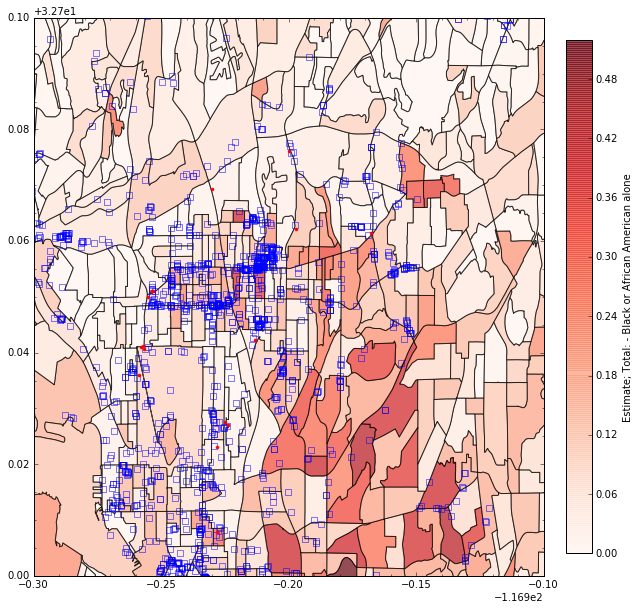

In [373]:
column_choice = 'Estimate; Total: - Black or African American alone'
fig,ax = plt.subplots(1,1, figsize=(10,10))
patches = []
for i in range(0,len(sdcounty_index)): 
    barf = pd.DataFrame(shapes[sdcounty_index[i]].points)
    poly = plt.Polygon(barf[[0,1]], fc='none', ec='k', alpha=0.7)
    patches.append(poly)
    #plt.gca().add_patch(poly)

colors = census_combo[column_choice]
p = PatchCollection(patches, cmap='Reds', alpha=0.7)
p.set_array(np.array(colors))
p.set_clim([min(colors),max(colors)])
ax.add_collection(p)
plt.colorbar(p, fraction=0.046, pad=0.04, shrink=1.0, label=column_choice)

#plt.plot(lighting['Geolocation (Longitude)'], lighting['Geolocation (Latitude)'], 'k.')
plt.plot(graffiti['Geolocation (Longitude)'], graffiti['Geolocation (Latitude)'], 'bs', mfc='none', mec='b')
plt.plot(dump['Geolocation (Longitude)'], dump['Geolocation (Latitude)'], 'r.')

plt.ylim(32.7,32.8)
plt.xlim(-117.2,-117.0)

#plt.axis('scaled')
plt.minorticks_on()

plt.show()

### Look at how different block groups cluster in terms of demographics

In [375]:
X = StandardScaler().fit_transform(census_combo[['Estimate; Male:', 'Estimate; Female:',
                                                 'Estimate; Total: - White alone',
                                                 'Estimate; Total: - Black or African American alone', 
                                                 'Estimate; Total: - American Indian and Alaska Native alone', 
                                                 'Estimate; Total: - Asian alone',
                                                 'Estimate; Total: - Native Hawaiian and Other Pacific Islander alone',
                                                 'Estimate; Total: - Some other race alone','Estimate; Total: - Two or more races:',
                                                 'Estimate; Total: - Owner occupied']])



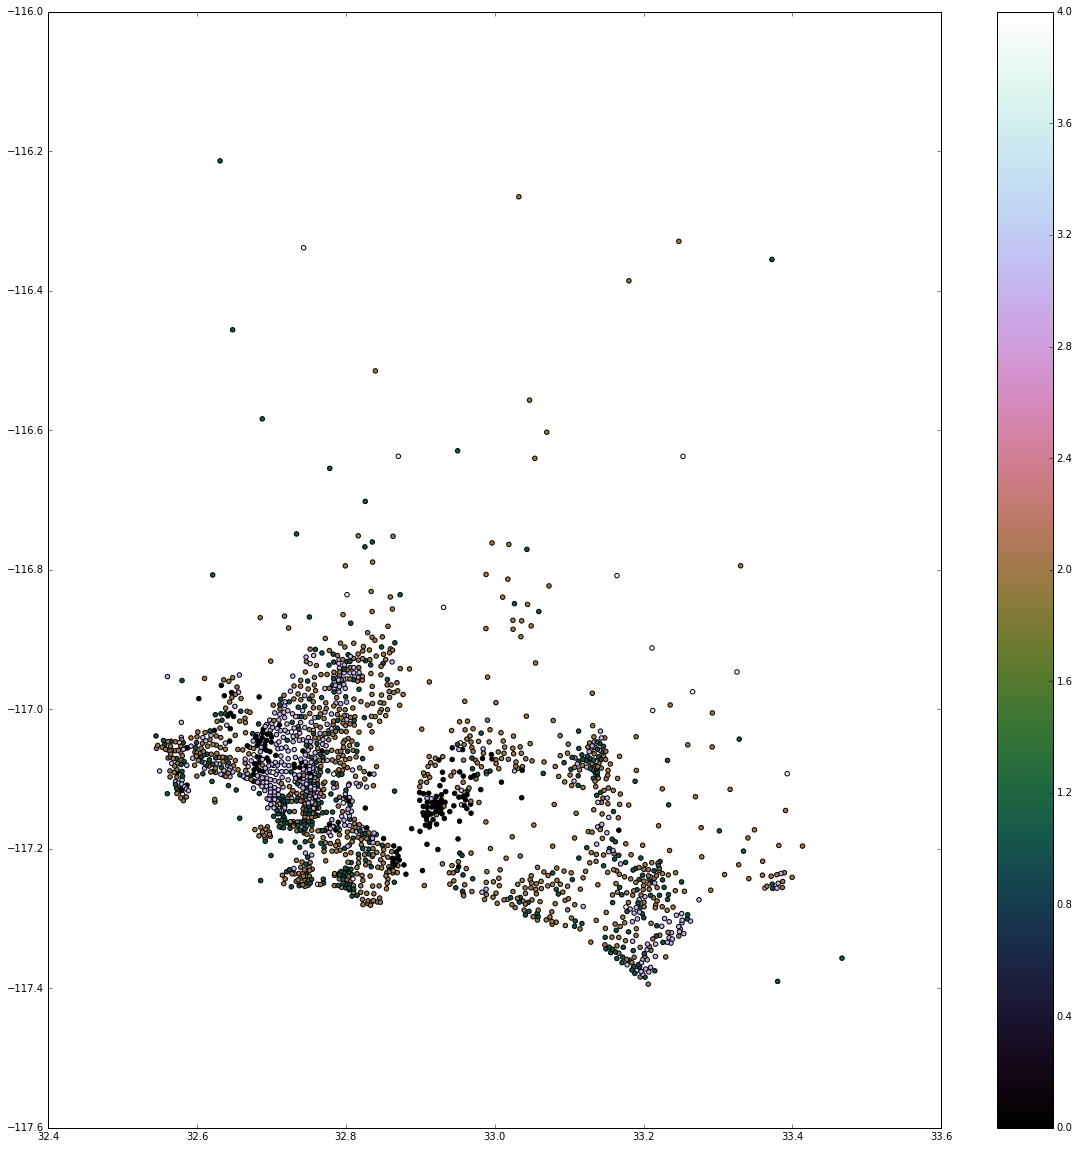

In [396]:
random_state = 170
# Incorrect number of clusters
y_pred = KMeans(n_clusters=5, n_init=10, random_state=random_state).fit_predict(X)

plt.subplots(1,1, figsize=(20,20))
plt.scatter(census_combo[10].astype(float), census_combo[11].astype(float), c=y_pred, cmap='cubehelix')
plt.colorbar()


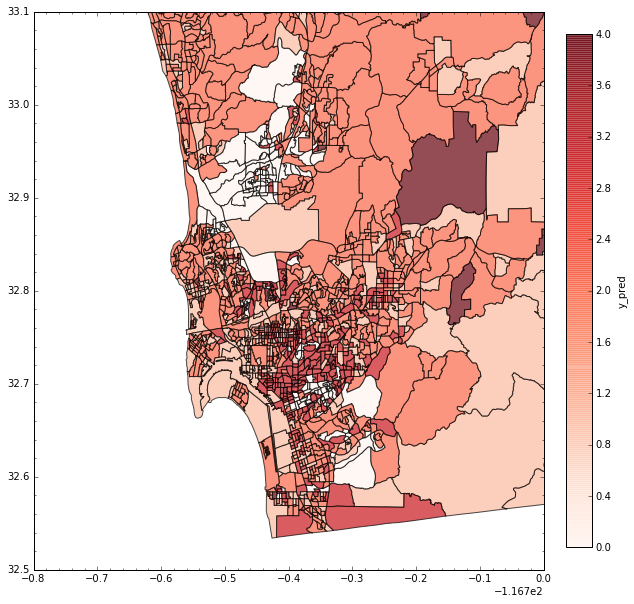

In [397]:
fig,ax = plt.subplots(1,1, figsize=(10,10))
patches = []
for i in range(0,len(sdcounty_index)): 
    barf = pd.DataFrame(shapes[sdcounty_index[i]].points)
    poly = plt.Polygon(barf[[0,1]], fc='none', ec='k', alpha=0.7)
    patches.append(poly)
    #plt.gca().add_patch(poly)

colors = y_pred
p = PatchCollection(patches, cmap='Reds', alpha=0.7)
p.set_array(np.array(colors))
p.set_clim([min(colors),max(colors)])
ax.add_collection(p)
plt.colorbar(p, fraction=0.046, pad=0.04, shrink=1.0, label='y_pred')

#plt.plot(lighting['Geolocation (Longitude)'], lighting['Geolocation (Latitude)'], 'k.')
#plt.plot(graffiti['Geolocation (Longitude)'], graffiti['Geolocation (Latitude)'], 'bs', mfc='none', mec='b')
#plt.plot(dump['Geolocation (Longitude)'], dump['Geolocation (Latitude)'], 'r.')

plt.ylim(32.5,33.1)
plt.xlim(-117.5,-116.7)

#plt.axis('scaled')
plt.minorticks_on()

plt.show()

In [393]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [400]:
silhouette_avg = silhouette_score(X, y_pred)
print silhouette_avg

0.188818502978


In [406]:
cluster_start = np.arange(5,50,5)
for i in cluster_start: 
    y_pred = KMeans(n_clusters=i, n_init=25, random_state=random_state).fit_predict(X)
    silhouette_avg = silhouette_score(X, y_pred)
    
    print("For n_clusters =", i, "The average silhouette_score is :", silhouette_avg)



('For n_clusters =', 5, 'The average silhouette_score is :', 0.18954920770259498)
('For n_clusters =', 10, 'The average silhouette_score is :', 0.19261669215028998)
('For n_clusters =', 15, 'The average silhouette_score is :', 0.16226202435795206)
('For n_clusters =', 20, 'The average silhouette_score is :', 0.14897433255210094)
('For n_clusters =', 25, 'The average silhouette_score is :', 0.14444159542714768)
('For n_clusters =', 30, 'The average silhouette_score is :', 0.1533157735706992)
('For n_clusters =', 35, 'The average silhouette_score is :', 0.14509799963620512)
('For n_clusters =', 40, 'The average silhouette_score is :', 0.14524052850185387)
('For n_clusters =', 45, 'The average silhouette_score is :', 0.13742316593250911)


In [421]:
db = DBSCAN(eps=0.6, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

Estimated number of clusters: 2
Silhouette Coefficient: -0.168
